In [95]:
#Linear regression
from sklearn.linear_model import LinearRegression

#Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

import csv
import pandas as pd
from collections import defaultdict
import numpy as np

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
plt.rcParams['figure.dpi'] = 360

In [96]:
rosettes = [3,6,7,11,12,13,14,15,18,19]

### Create graph

In [97]:
def graph_r(r):

    nodes = []
    edges = []
    edges_distances = []

    with open(f'./data/rosette{r}_nodes.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                values = list(row.values())
                n = []
                n.append(float(values[0]))
                n.append(float(values[1]))
                n.extend(22.5-2.5*np.log10([float(n) for n in values[2:-1]]))
                n.append(np.log10(float(values[-1])))
                nodes.append(n)

    with open(f'./data/rosette{r}_edges.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                edges_distances.append([float(n) for n in list(row.values())])
                edges.append([float(n) for n in list(row.values())][:2])

    return (nodes,edges,edges_distances)

In [98]:
nodes, edges, distances = graph_r(rosettes[0])

### Correlation matrix

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_53652/1155875418.py:8: RuntimeWarning: divide by zero encountered in log10
  ed = [np.log10(c[n[0]]) for n in nodes]


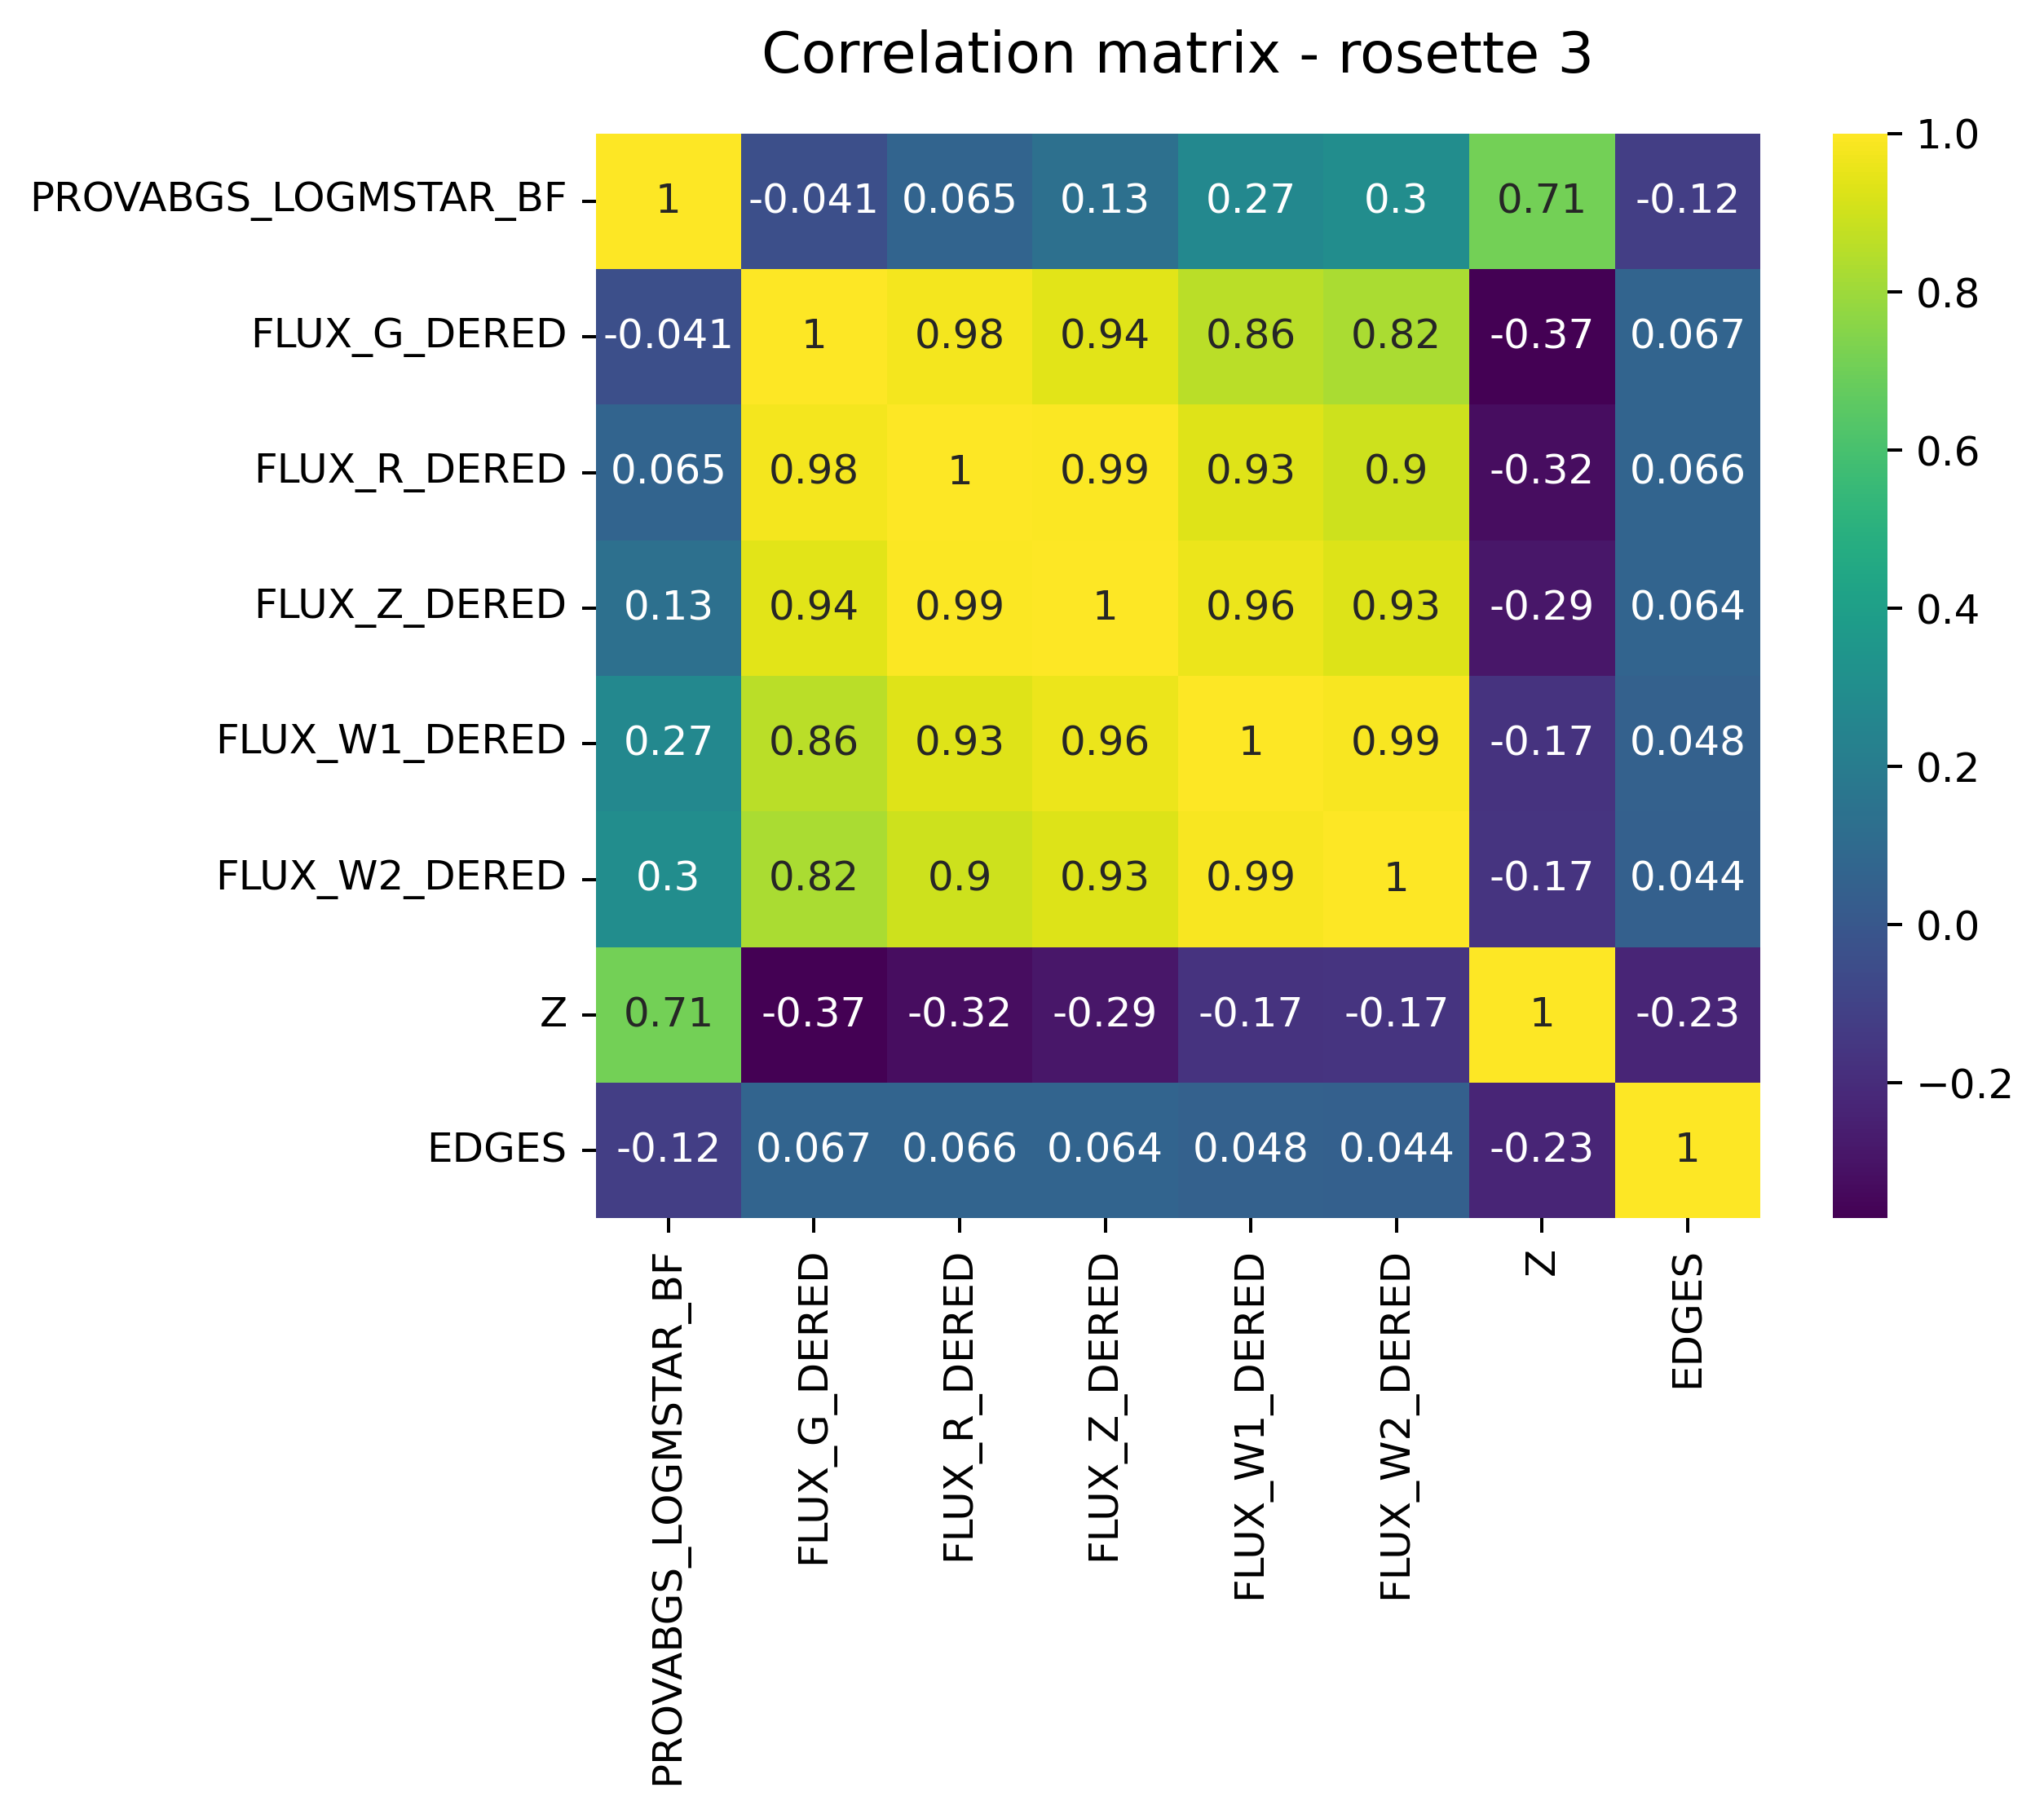

In [99]:
def correlation_matrix(r,nodes,edges):

    df = pd.read_csv(f'./data/rosette{r}_nodes.csv')
    c = defaultdict(int)
    for edge in edges:
        c[edge[0]] += 1
        c[edge[1]] += 1
    ed = [np.log10(c[n[0]]) for n in nodes]
    df['EDGES'] = ed

    df.drop('TARGET_ID', axis=1, inplace=True)
    matrix = sb.heatmap(df.corr(), cmap="viridis", annot=True)
    matrix.set_title(f'Correlation matrix - rosette {r}', fontsize=14, pad=15)
    plt.show()

correlation_matrix(3,nodes,edges)

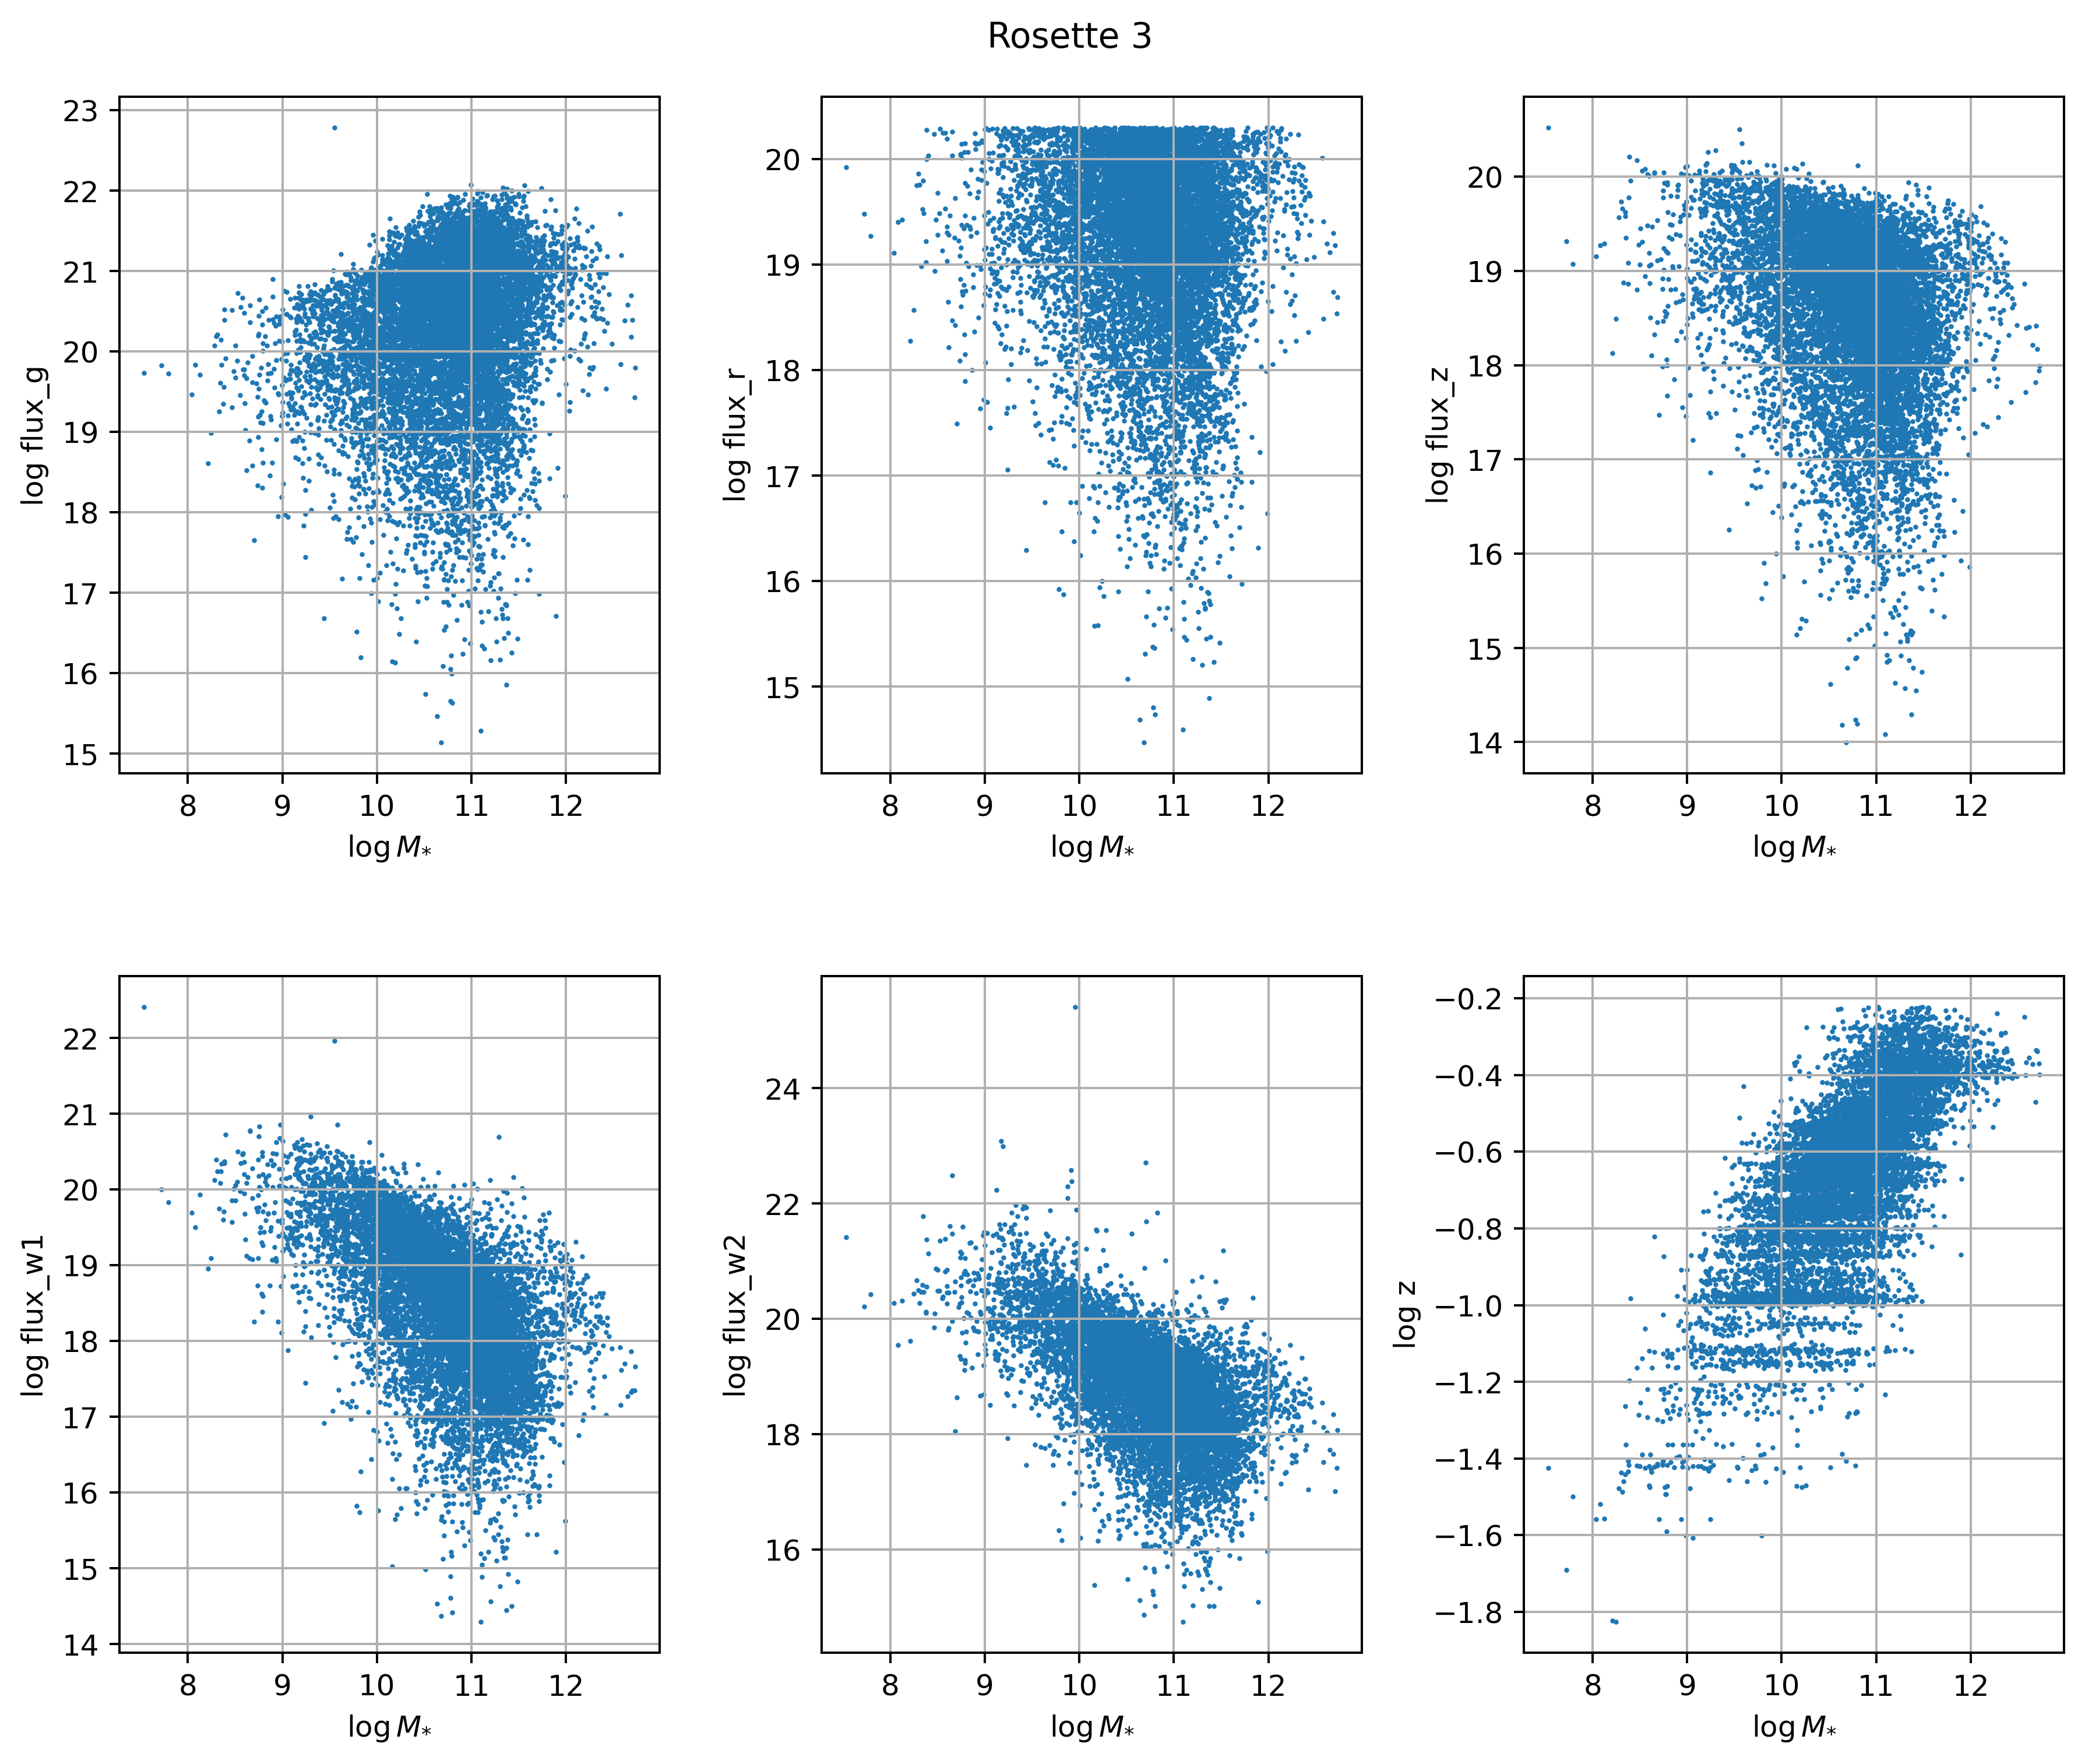

In [100]:
props = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']
nodes, _, _ = graph_r(3)

m = [n[1] for n in nodes]
flux = np.array([n[2:] for n in nodes])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle(r'Rosette 3', y=1.02)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i in range(2):
    for j in range(3):
        axes[i, j].scatter(m, flux[:,i*3+j], s=0.5)
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'log {props[i*3+j]}')
        axes[i, j].grid()

## Models

### Linear Model

#### Including **one** [flux_g, flux_r, flux_z, flux_w1, flux_w2, z]

In [101]:
props = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']
x_pred, y_pred, mses = [], [], []

for p in range(len(props)):
    X, y = [], []
    model = LinearRegression()

    for r in rosettes[:1]: #* Rosette 3
        nodes, _, _ = graph_r(r)
        y.extend(np.array([n[p+2] for n in nodes])) #input flux-z
        X.extend(np.array([n[1] for n in nodes]).reshape(-1, 1)) #mass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)
    model.fit(X_train, y_train)

    x_pred.append([t[0] for t in X_test])
    y_pred.append((y_test,model.predict(X_test)))
    mses.append((model.score(X_test, y_test),mean_squared_error(y_test, model.predict(X_test))))
    print(f'R^2, {props[p]}: {mses[-1][0]}, mse: {mses[-1][1]}')

R^2, flux_g: 0.03199955175895097, mse: 0.8821078894673011
R^2, flux_r: 0.010115649440867513, mse: 0.6963155756476094
R^2, flux_z: 0.0799421644674232, mse: 0.6720364424312926
R^2, flux_w1: 0.31567260062092717, mse: 0.5534844953729369
R^2, flux_w2: 0.34905691988694365, mse: 0.5533607107063984
R^2, z: 0.5283927357810932, mse: 0.022188993604980015


Predictions in the same rosette

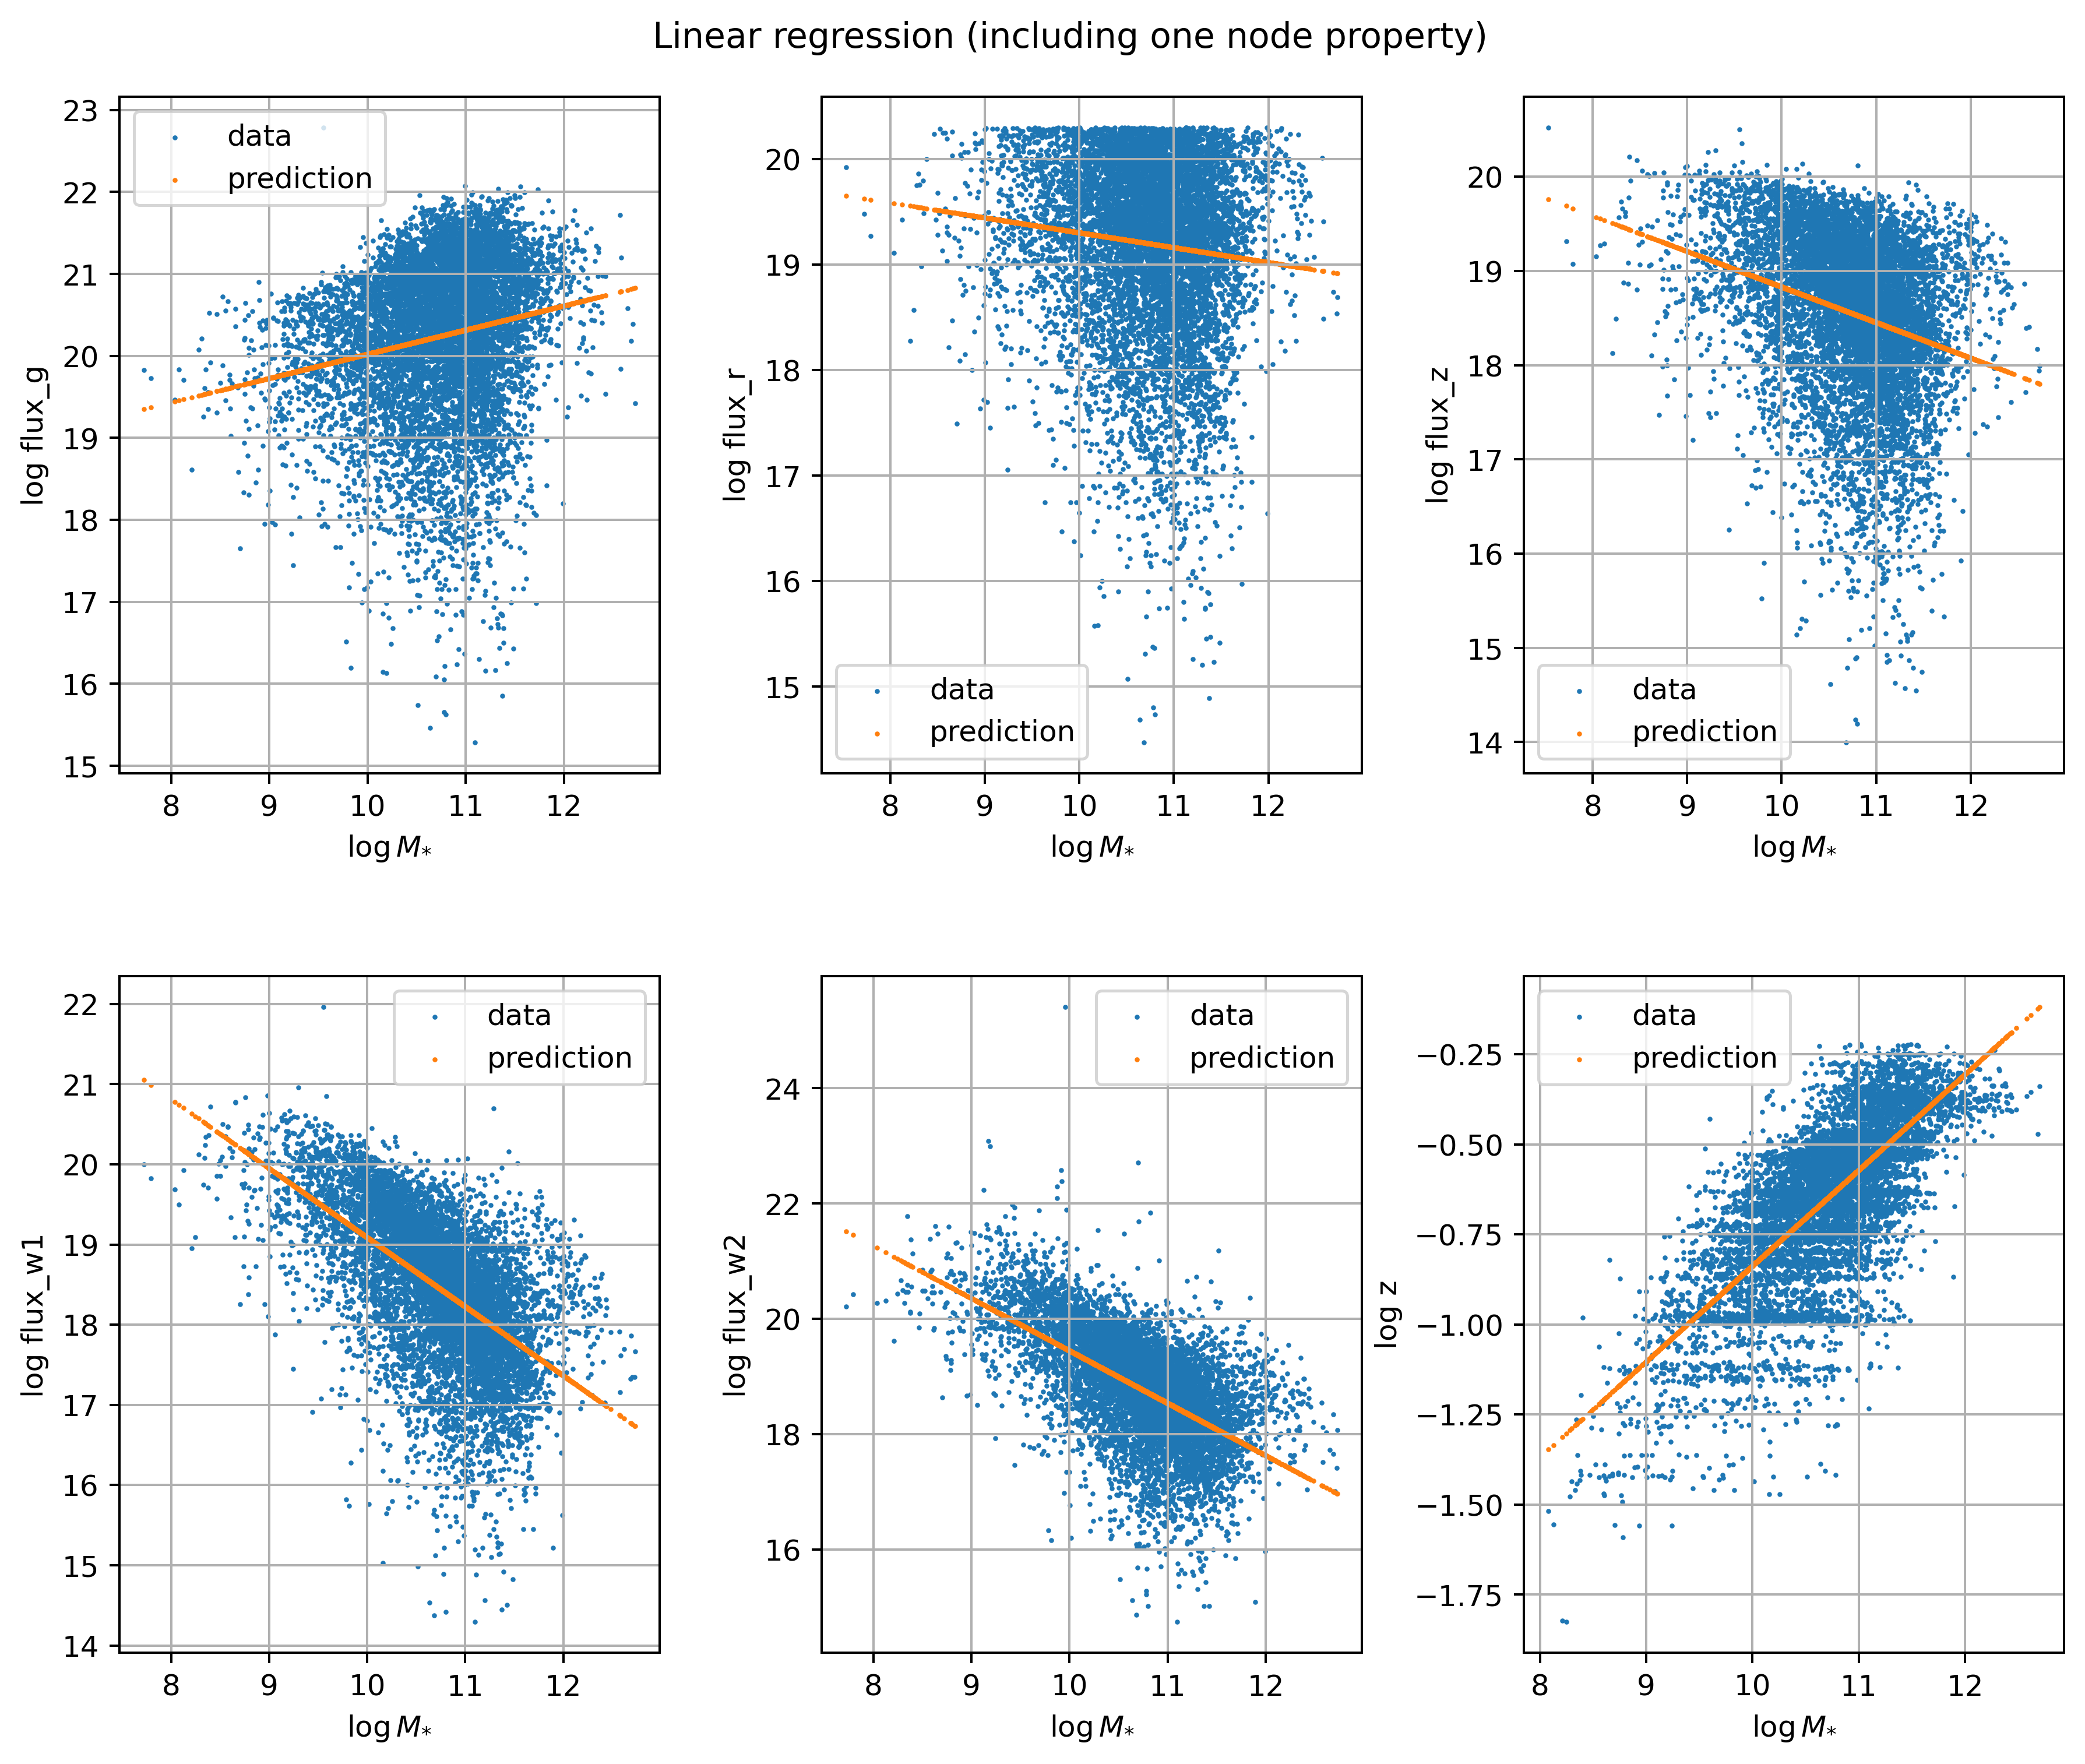

In [102]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

x_pred, y_pred = np.array(x_pred), np.array(y_pred)
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].scatter(x_pred[i*ncols+j], y_pred[i*ncols+j][0], s=0.5, label='data')
        axes[i, j].scatter(x_pred[i*ncols+j], y_pred[i*ncols+j][1], s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'log {props[i*ncols+j]}')
        axes[i, j].grid()

plt.suptitle('Linear regression (including one node property)', y=1.02)
plt.show()

Predictions in a different rosette

In [103]:
x_pred, y_pred = [], []

for p in range(len(props)):
    X, y, ms = [], [], []

    for r in rosettes[1:2]: #* Rosette 6
        nodes, _, _ = graph_r(r)
        y.extend(np.array([n[p+2] for n in nodes])) #input flux-z
        X.extend(np.array([n[1] for n in nodes]).reshape(-1, 1)) #mass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9) #*training

    x_pred.append([t[0] for t in X_test])
    y_pred.append((y_test,model.predict(X_test)))

    ms.append((model.score(X_test, y_test),mean_squared_error(y_test, model.predict(X_test))))
    print(f'R^2, {props[p]}: {ms[-1][0]}, mse: {ms[-1][1]}')

R^2, flux_g: -449.65009302073133, mse: 438.72173709333373
R^2, flux_r: -517.9747727605568, mse: 395.80807325932875
R^2, flux_z: -476.7362442460327, mse: 370.92540376496754
R^2, flux_w1: -431.4101059816153, mse: 366.1607604614993
R^2, flux_w2: -425.8256338460407, mse: 380.25152520118627
R^2, z: 0.5685449152116271, mse: 0.025531123843504724


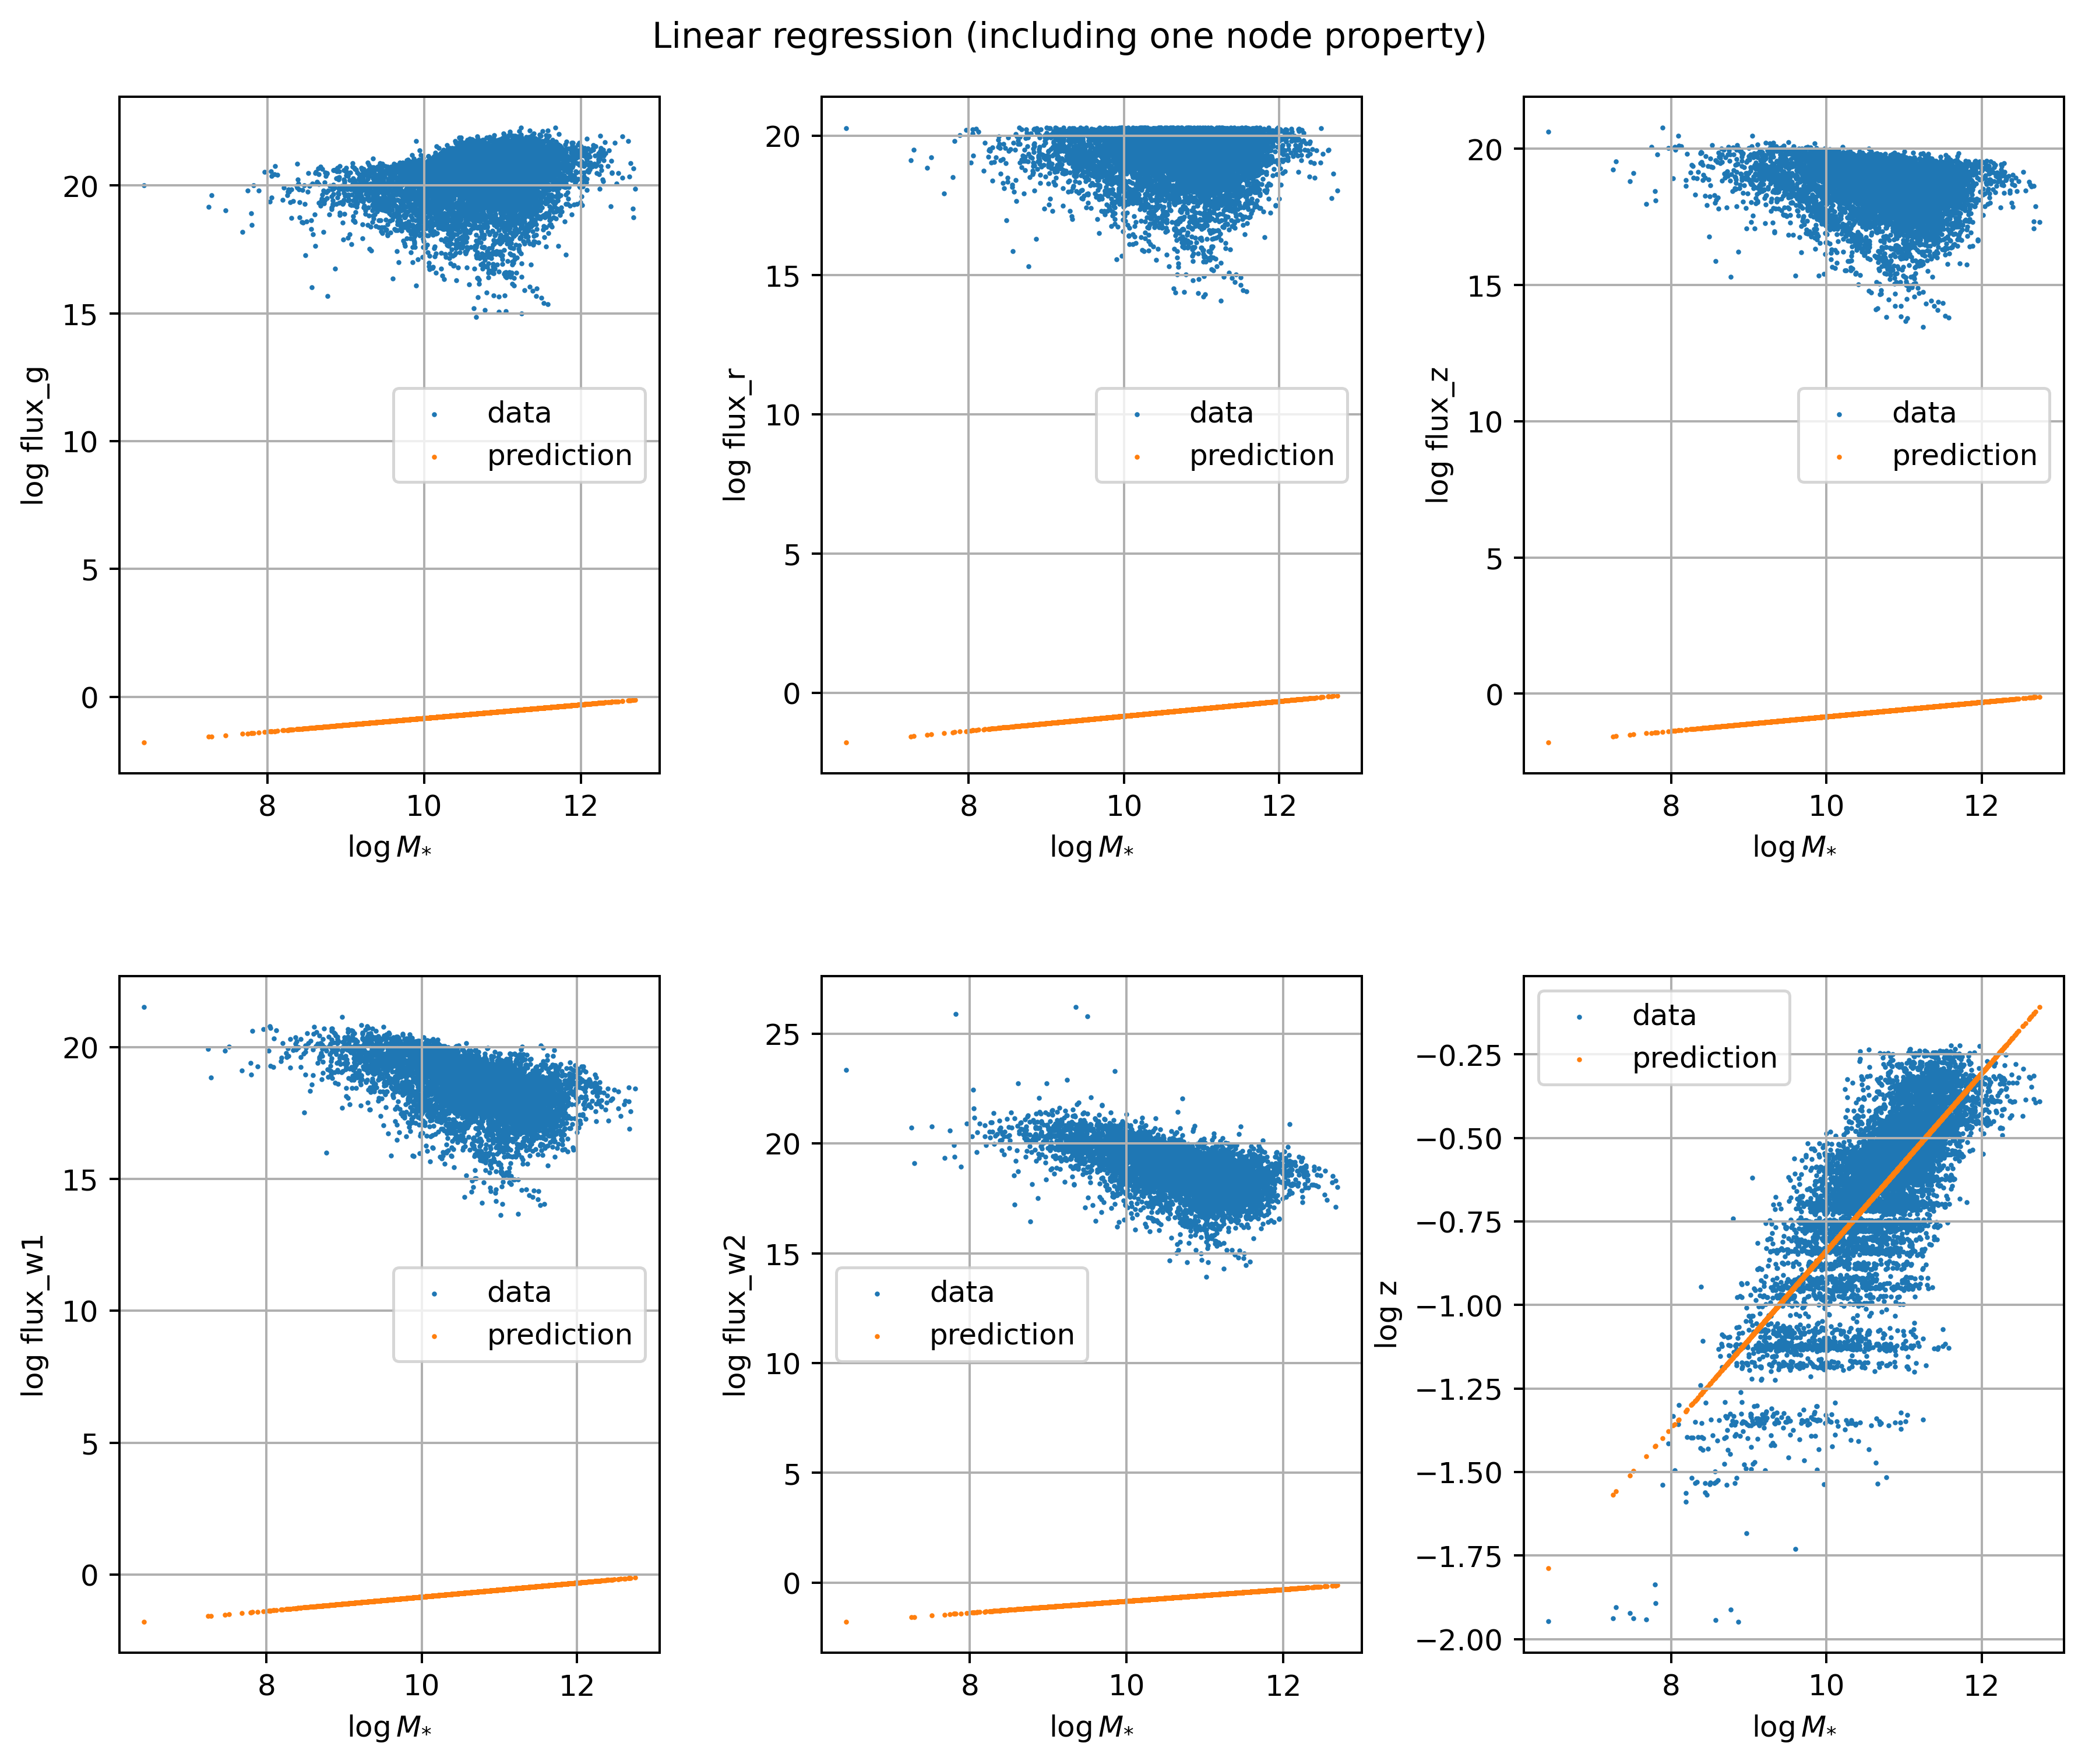

In [104]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

x_pred, y_pred = np.array(x_pred), np.array(y_pred)
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].scatter(x_pred[i*ncols+j], y_pred[i*ncols+j][0], s=0.5, label='data')
        axes[i, j].scatter(x_pred[i*ncols+j], y_pred[i*ncols+j][1], s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'log {props[i*ncols+j]}')
        axes[i, j].grid()

plt.suptitle('Linear regression (including one node property)', y=1.02)
plt.show()

#### Including **all** [flux_g, flux_r, flux_z, flux_w1, flux_w2, z]

In [105]:
model = LinearRegression()

X, y = [], []
for r in rosettes[:1]: #Rosette 3
    nodes, _, _ = graph_r(r)
    X.extend([[n[2],n[3],n[4],n[5],n[6],n[7]] for n in nodes])
    y.extend([n[1] for n in nodes])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)
model.fit(X_train, y_train)
print(f'R^2: {model.score(X_test, y_test)}')

R^2: 0.9090404510562706


Predictions in the same rosette

In [106]:
y_pred = model.predict(X_test)
print(f'R^2: {model.score(X_test, y_pred)}')
print(f'mse: {mean_squared_error(y_test, y_pred)}')

R^2: 1.0
mse: 0.03450655649191858


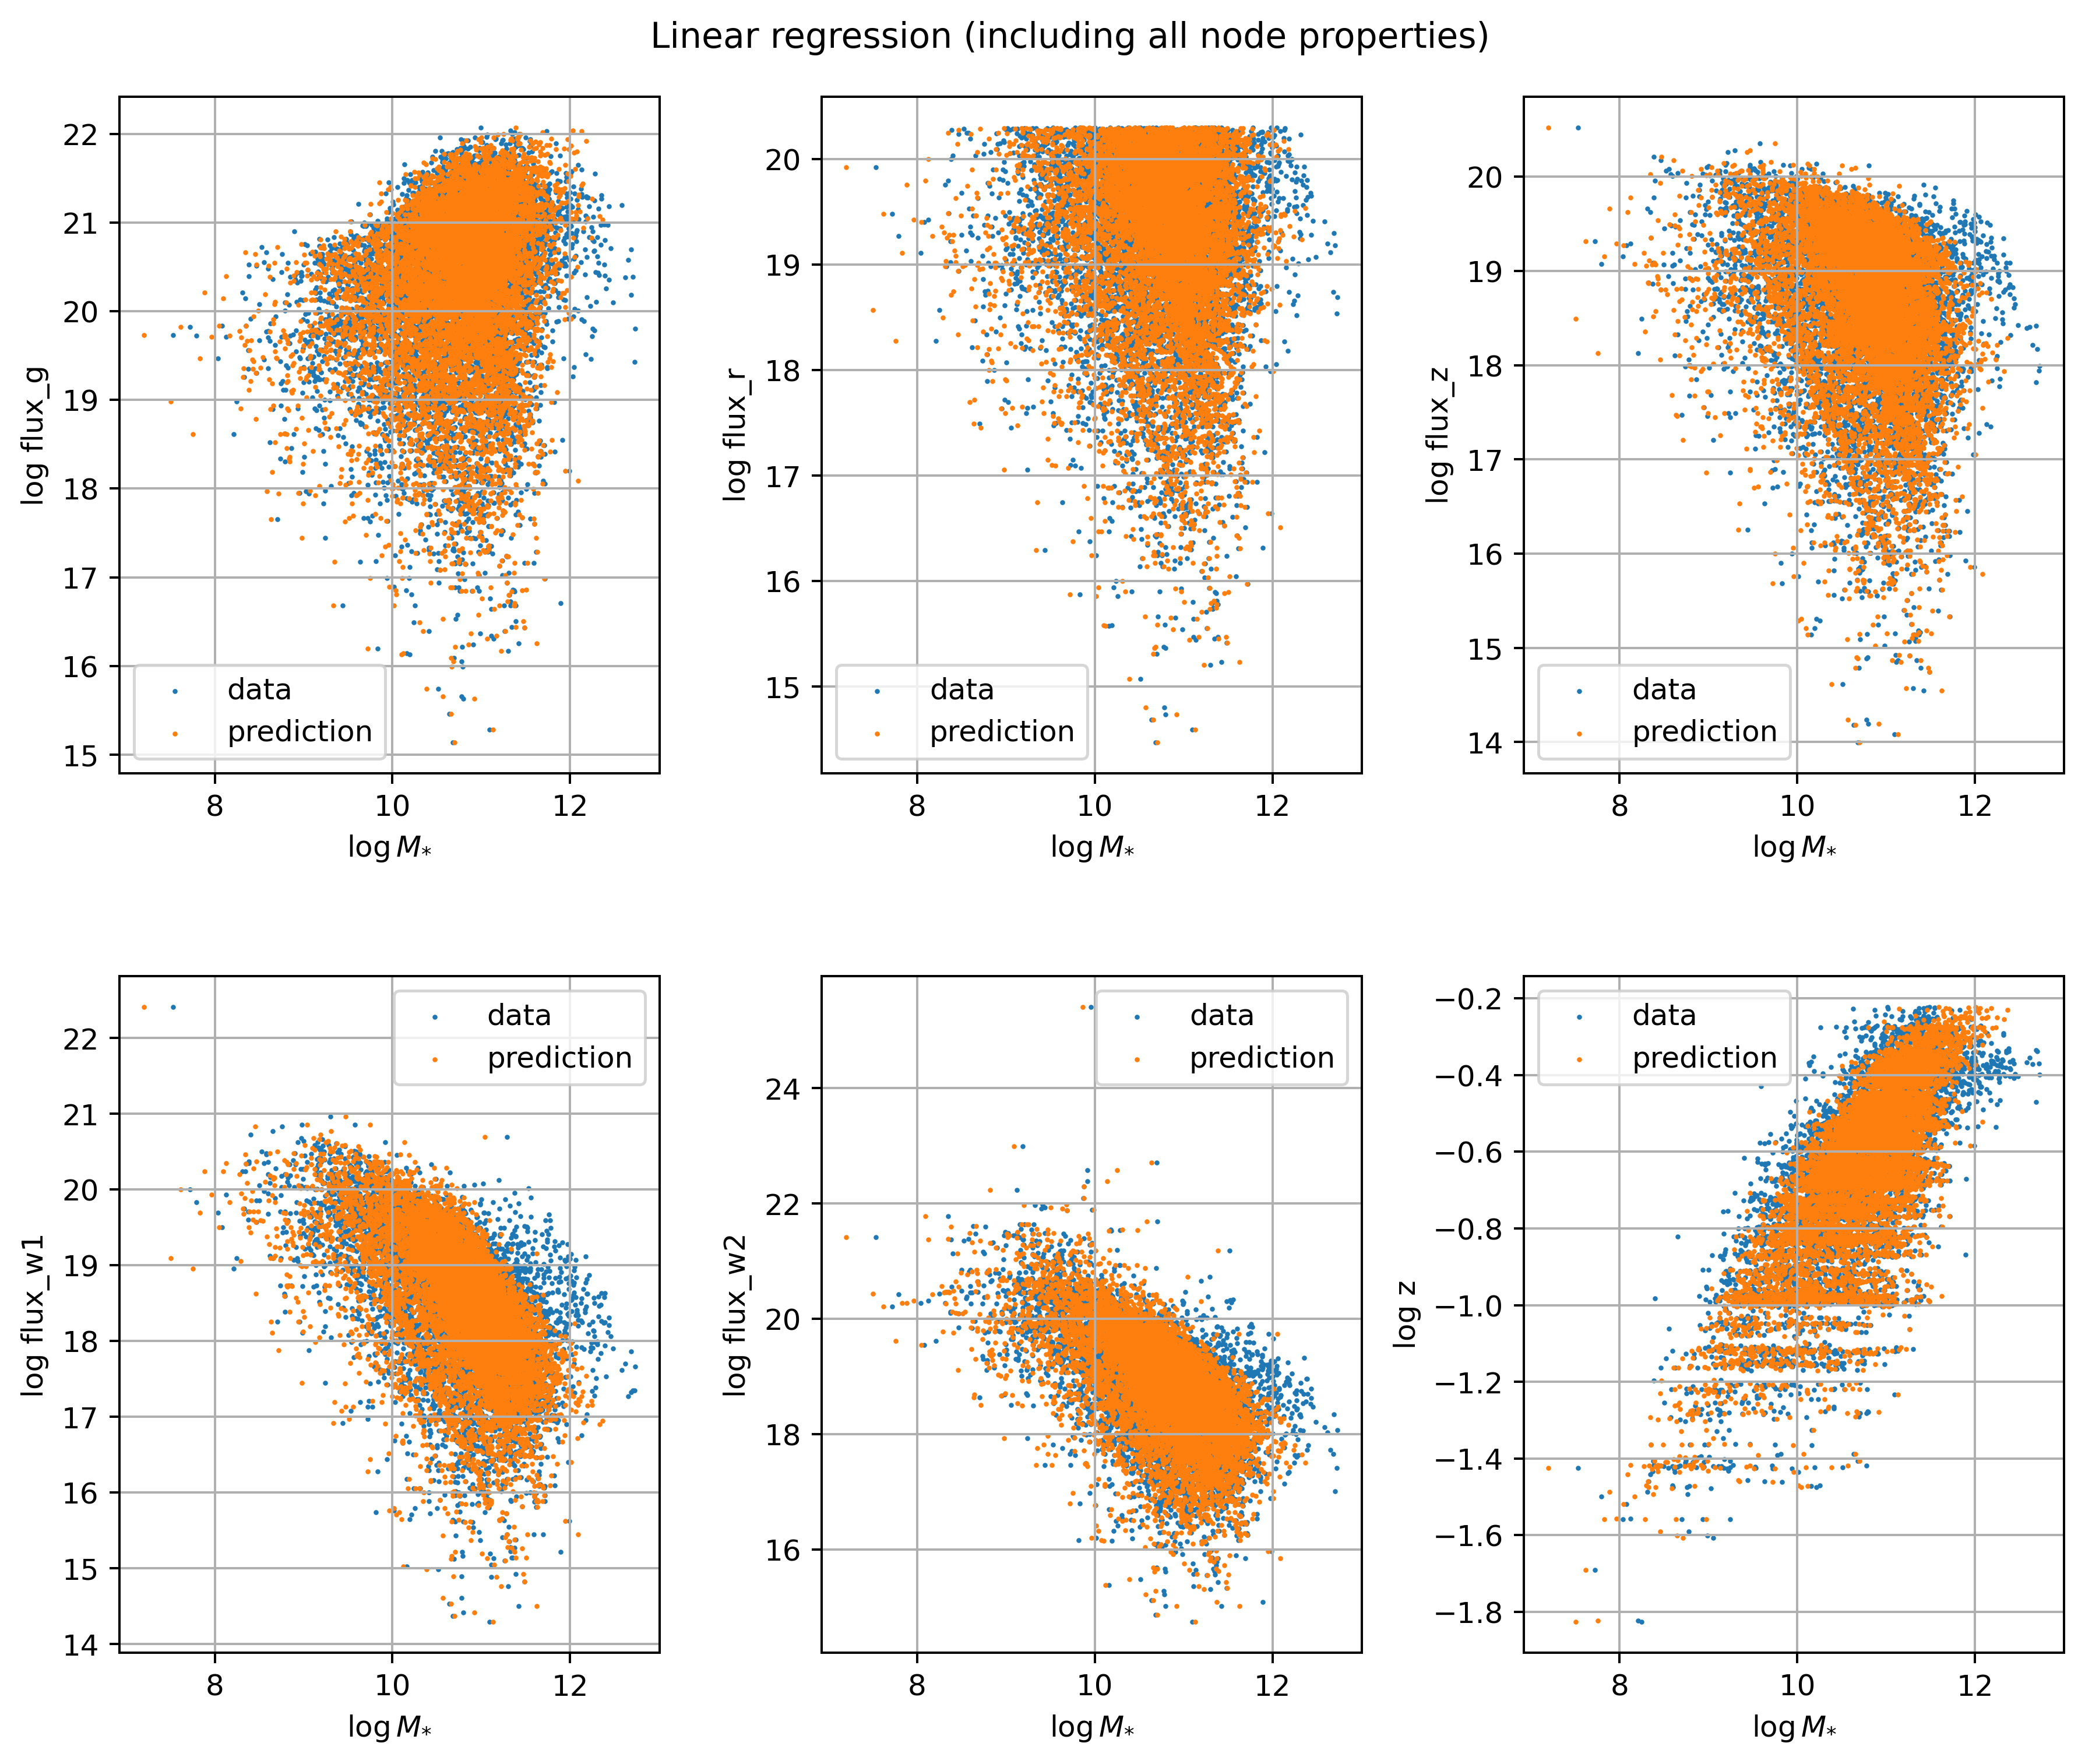

In [107]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

X_test, y_test, y_pred = np.array(X_test), np.array(y_test), np.array(y_pred)

for i in range(nrows):
    for j in range(ncols):
        prop_index = i * ncols + j
        prop_name = props[prop_index]
        axes[i, j].scatter(y_test, X_test[:, prop_index], s=0.5, label='data')
        axes[i, j].scatter(y_pred, X_test[:, prop_index], s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_ylabel(f'log {prop_name}')
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].grid()

plt.suptitle('Linear regression (including all node properties)', y=1.02)
plt.show()

Predictions in a different rosette

In [108]:
X, y = [], []
for r in rosettes[2:3]: #rosette 7
    nodes, _, _ = graph_r(r)
    X.extend([[n[2],n[3],n[4],n[5],n[6],n[7]] for n in nodes])
    y.extend([n[1] for n in nodes])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)
y_pred = model.predict(X_test)
print(f'R^2: {model.score(X_test, y_test)}')
print(f'mse: {mean_squared_error(y_test, y_pred)}')

R^2: 0.9132868885680364
mse: 0.037146707936748916


In [109]:
X, y = [], []
for r in rosettes[1:2]: #rosette 6
    nodes, _, _ = graph_r(r)
    X.extend([[n[2],n[3],n[4],n[5],n[6],n[7]] for n in nodes])
    y.extend([n[1] for n in nodes])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8)
y_pred = model.predict(X_test)
print(f'R^2: {model.score(X_test, y_test)}')
print(f'mse: {mean_squared_error(y_test, y_pred)}')

R^2: 0.9130986746483113
mse: 0.03766368602640159


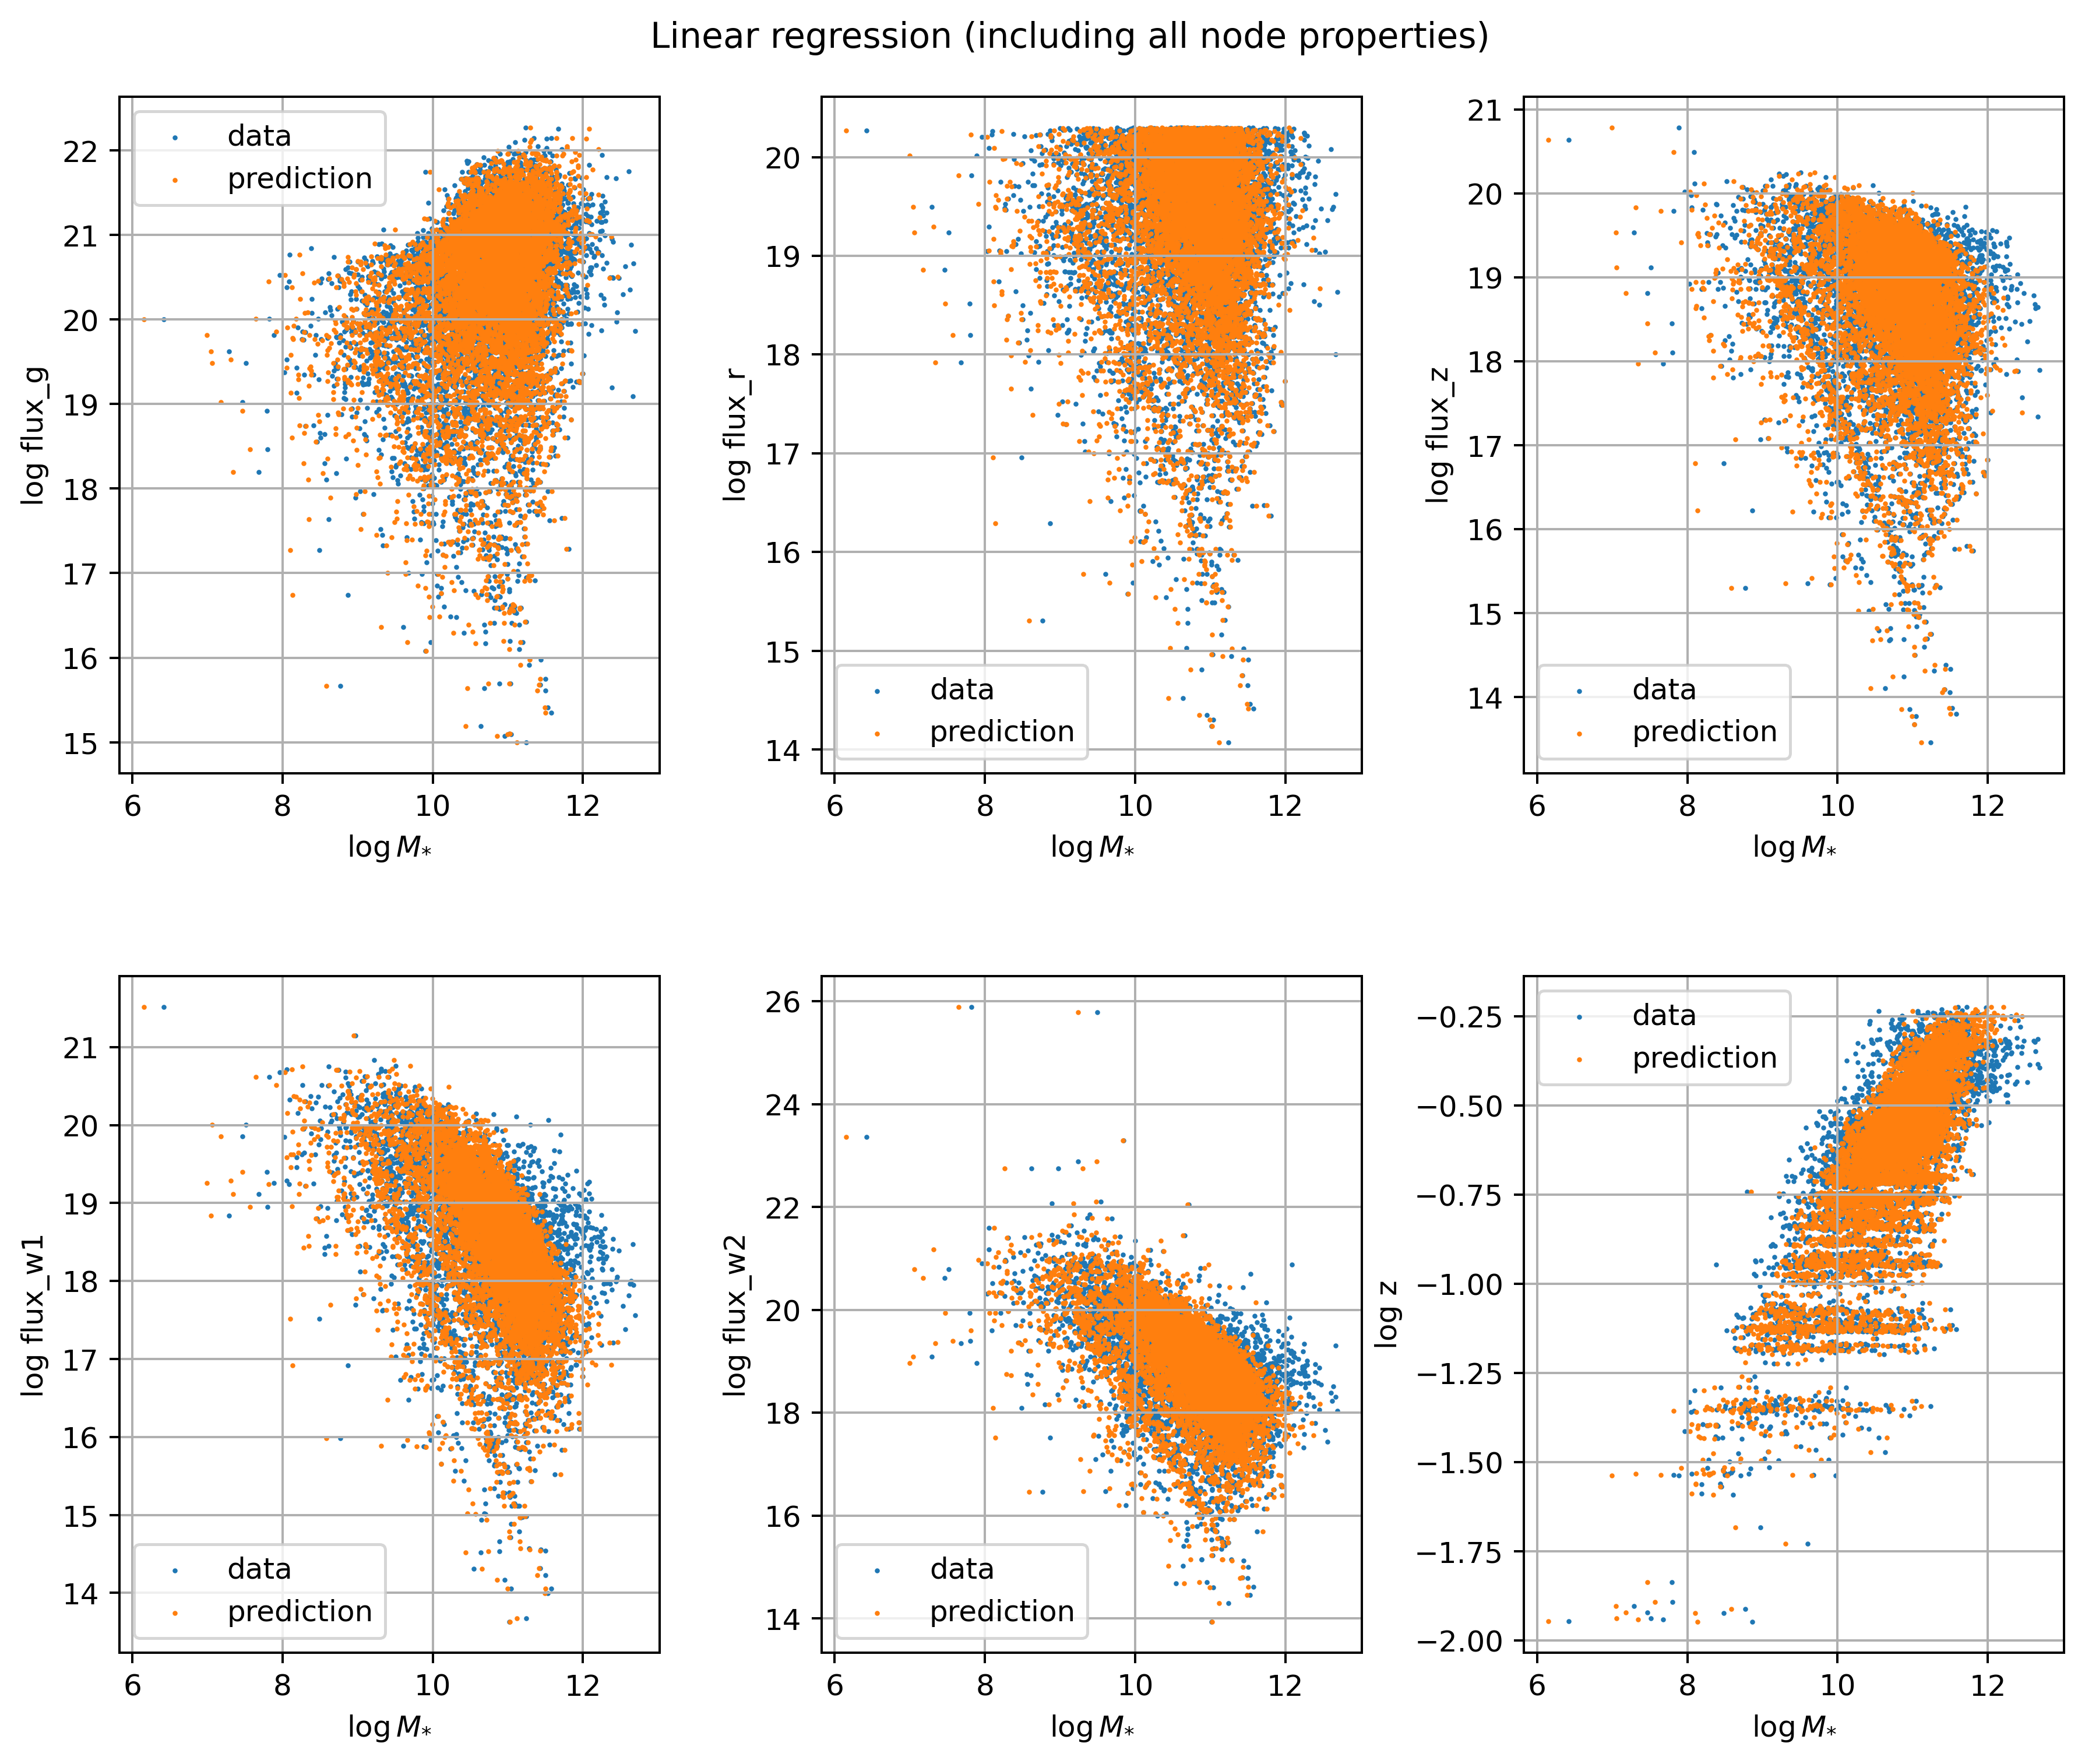

In [110]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

X_test, y_test, y_pred = np.array(X_test), np.array(y_test), np.array(y_pred)

for i in range(nrows):
    for j in range(ncols):
        prop_index = i * ncols + j
        prop_name = props[prop_index]
        axes[i, j].scatter(y_test, X_test[:, prop_index], s=0.5, label='data')  # Datos reales
        axes[i, j].scatter(y_pred, X_test[:, prop_index], s=0.5, label='prediction')  # Predicciones
        axes[i, j].legend()
        axes[i, j].set_ylabel(f'log {prop_name}')
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].grid()

plt.suptitle('Linear regression (including all node properties)', y=1.02)
plt.show()

### Random Forest

In [111]:
nodes, _, _ = graph_r(rosettes[0])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.03571028973132311


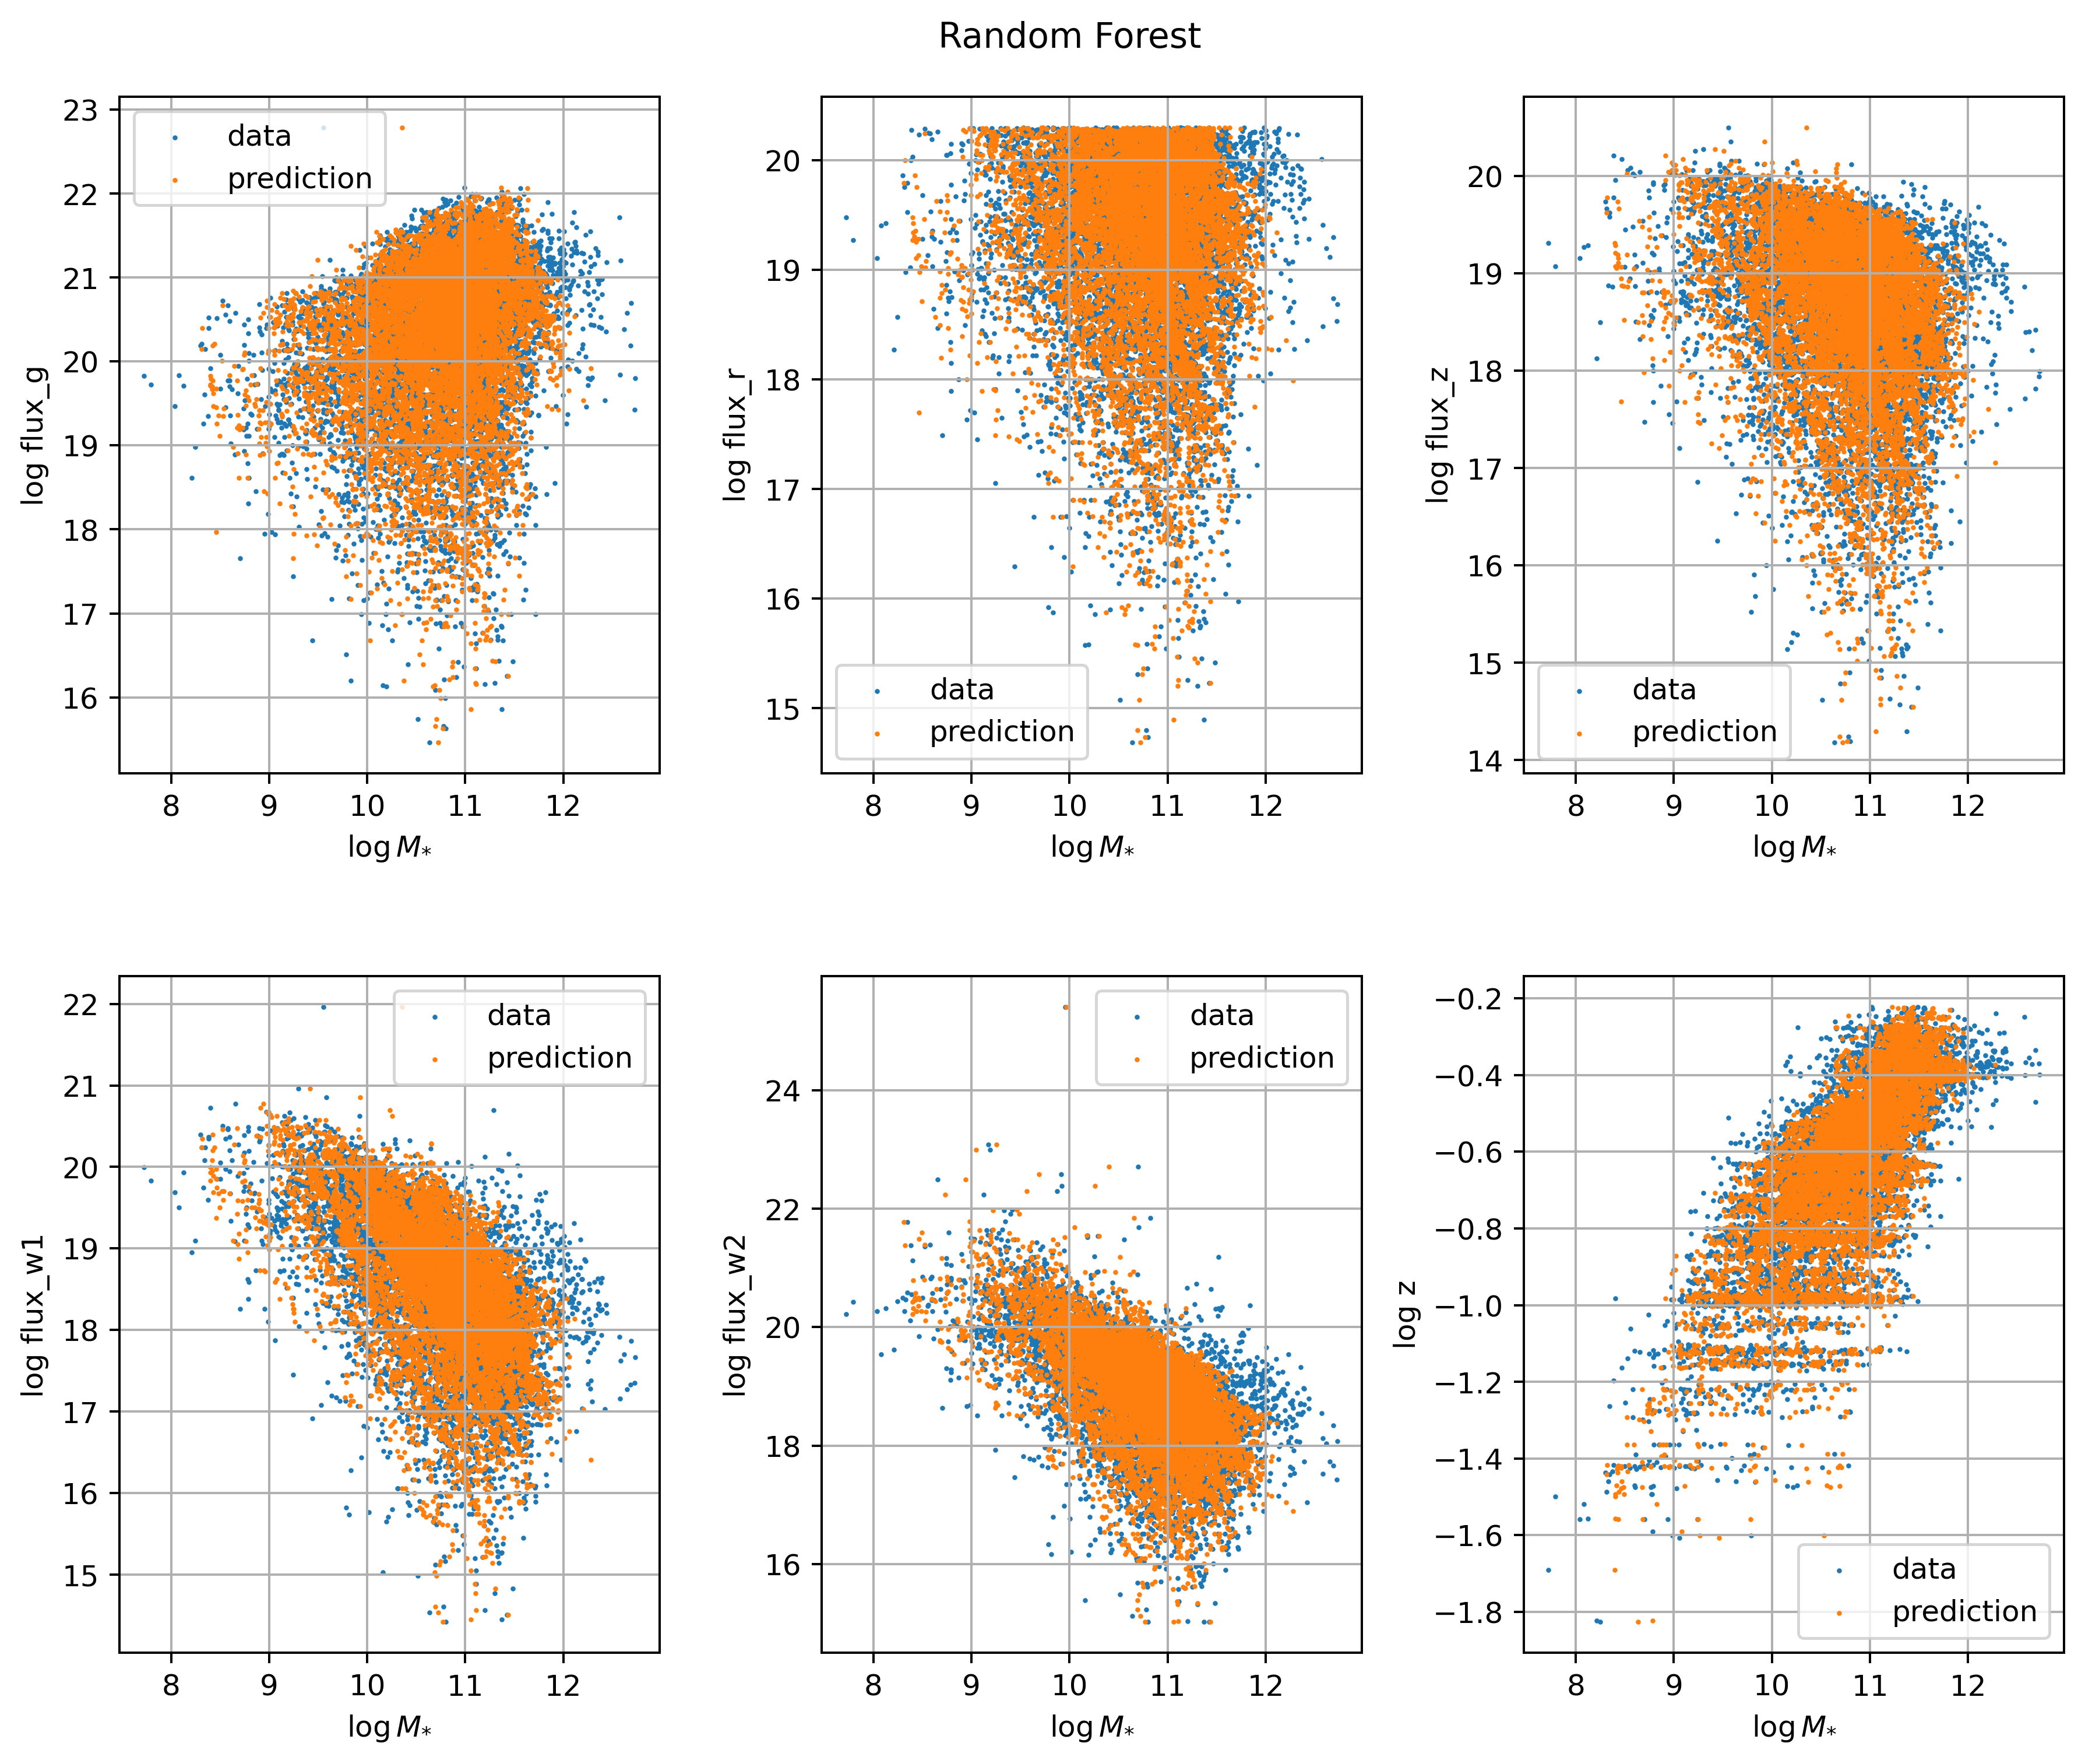

In [112]:
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle('Random Forest', y=1.02)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

X_test, y_test, y_pred = np.array(X_test), np.array(y_test), np.array(y_pred)

labels = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']

for i in range(2):
    for j in range(3):
        prop_index = i * 3 + j
        axes[i, j].scatter(y_test, X_test[:, prop_index], s=0.5, label='data')
        axes[i, j].scatter(y_pred, X_test[:, prop_index], s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'log {labels[prop_index]}')
        axes[i, j].grid()

plt.show()

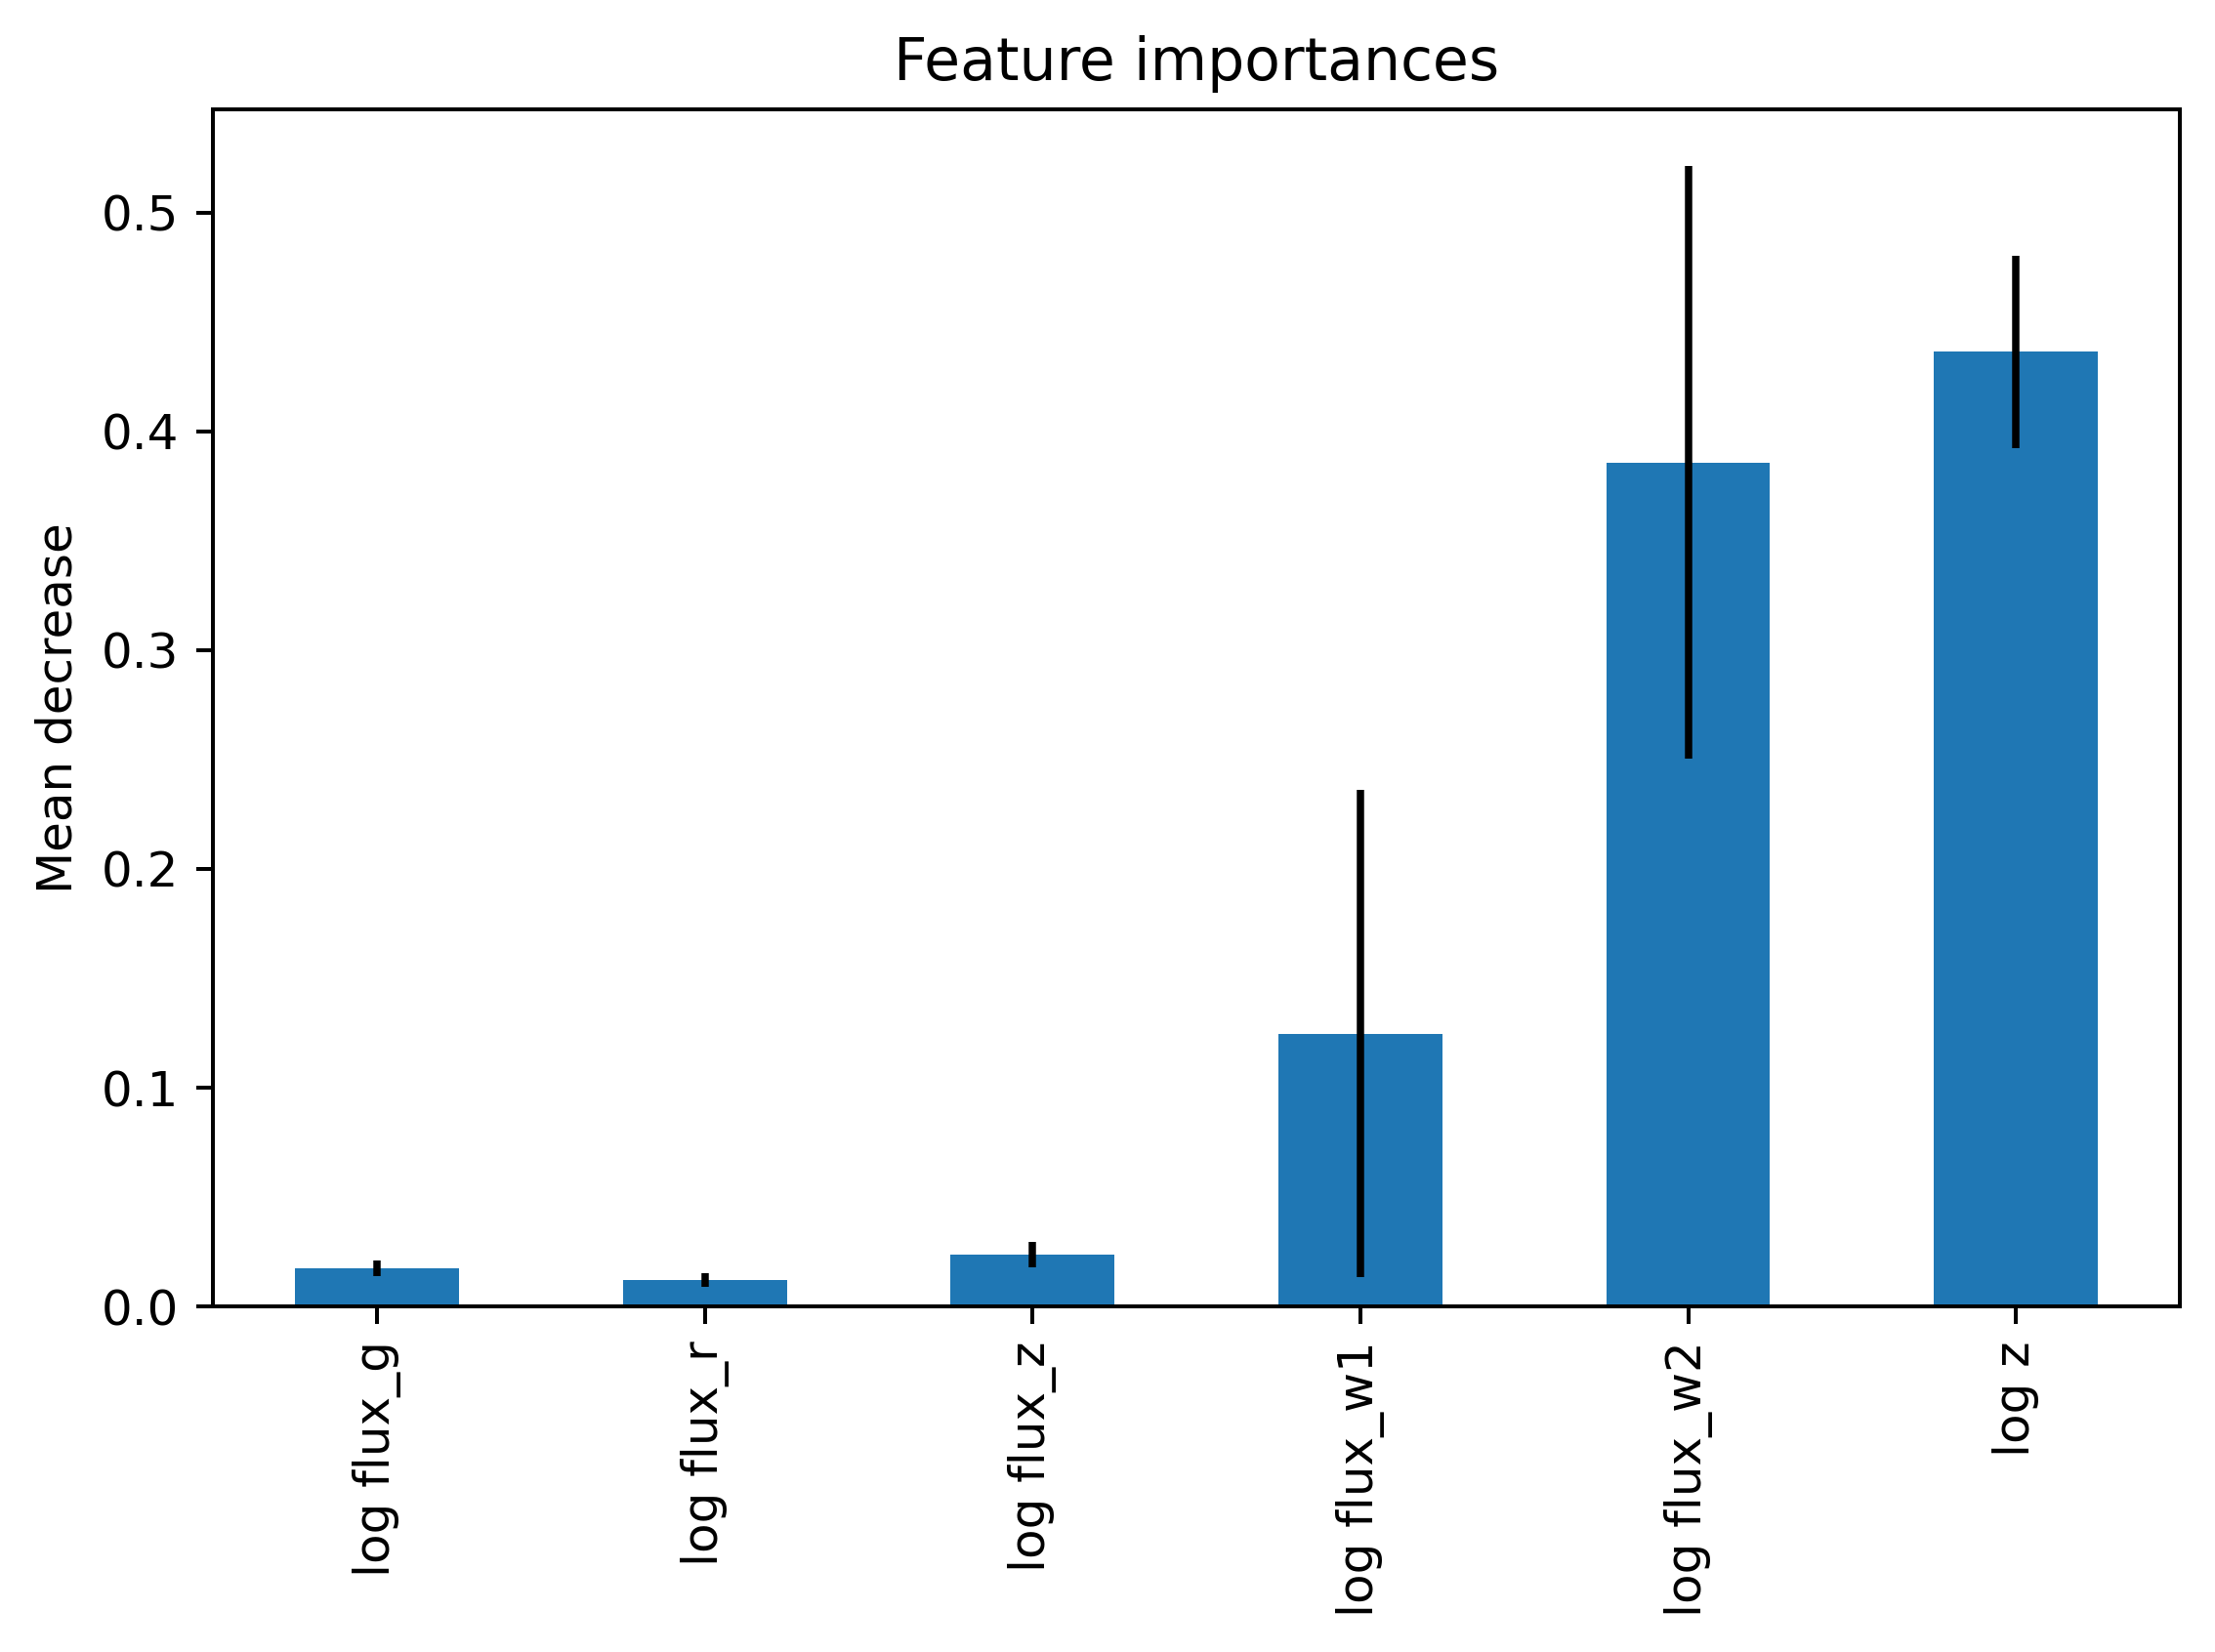

In [113]:
props = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

feature_names = [f"log {i}" for i in props]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease")
fig.tight_layout()

Adding a random column

In [114]:
nodes, _, _ = graph_r(rosettes[0])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
regressor_rdm = RandomForestRegressor(n_estimators=100, random_state=0)

random_column = np.random.rand(len(y_train)) #random column
X_train_extended = np.column_stack((X_train, random_column))
regressor_rdm.fit(X_train_extended, y_train)

X_test_extended = np.column_stack((X_test, np.random.rand(len(y_test))))
y_pred_extended = regressor_rdm.predict(X_test_extended)

mse = mean_squared_error(y_test, y_pred_extended)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.03602147576872173


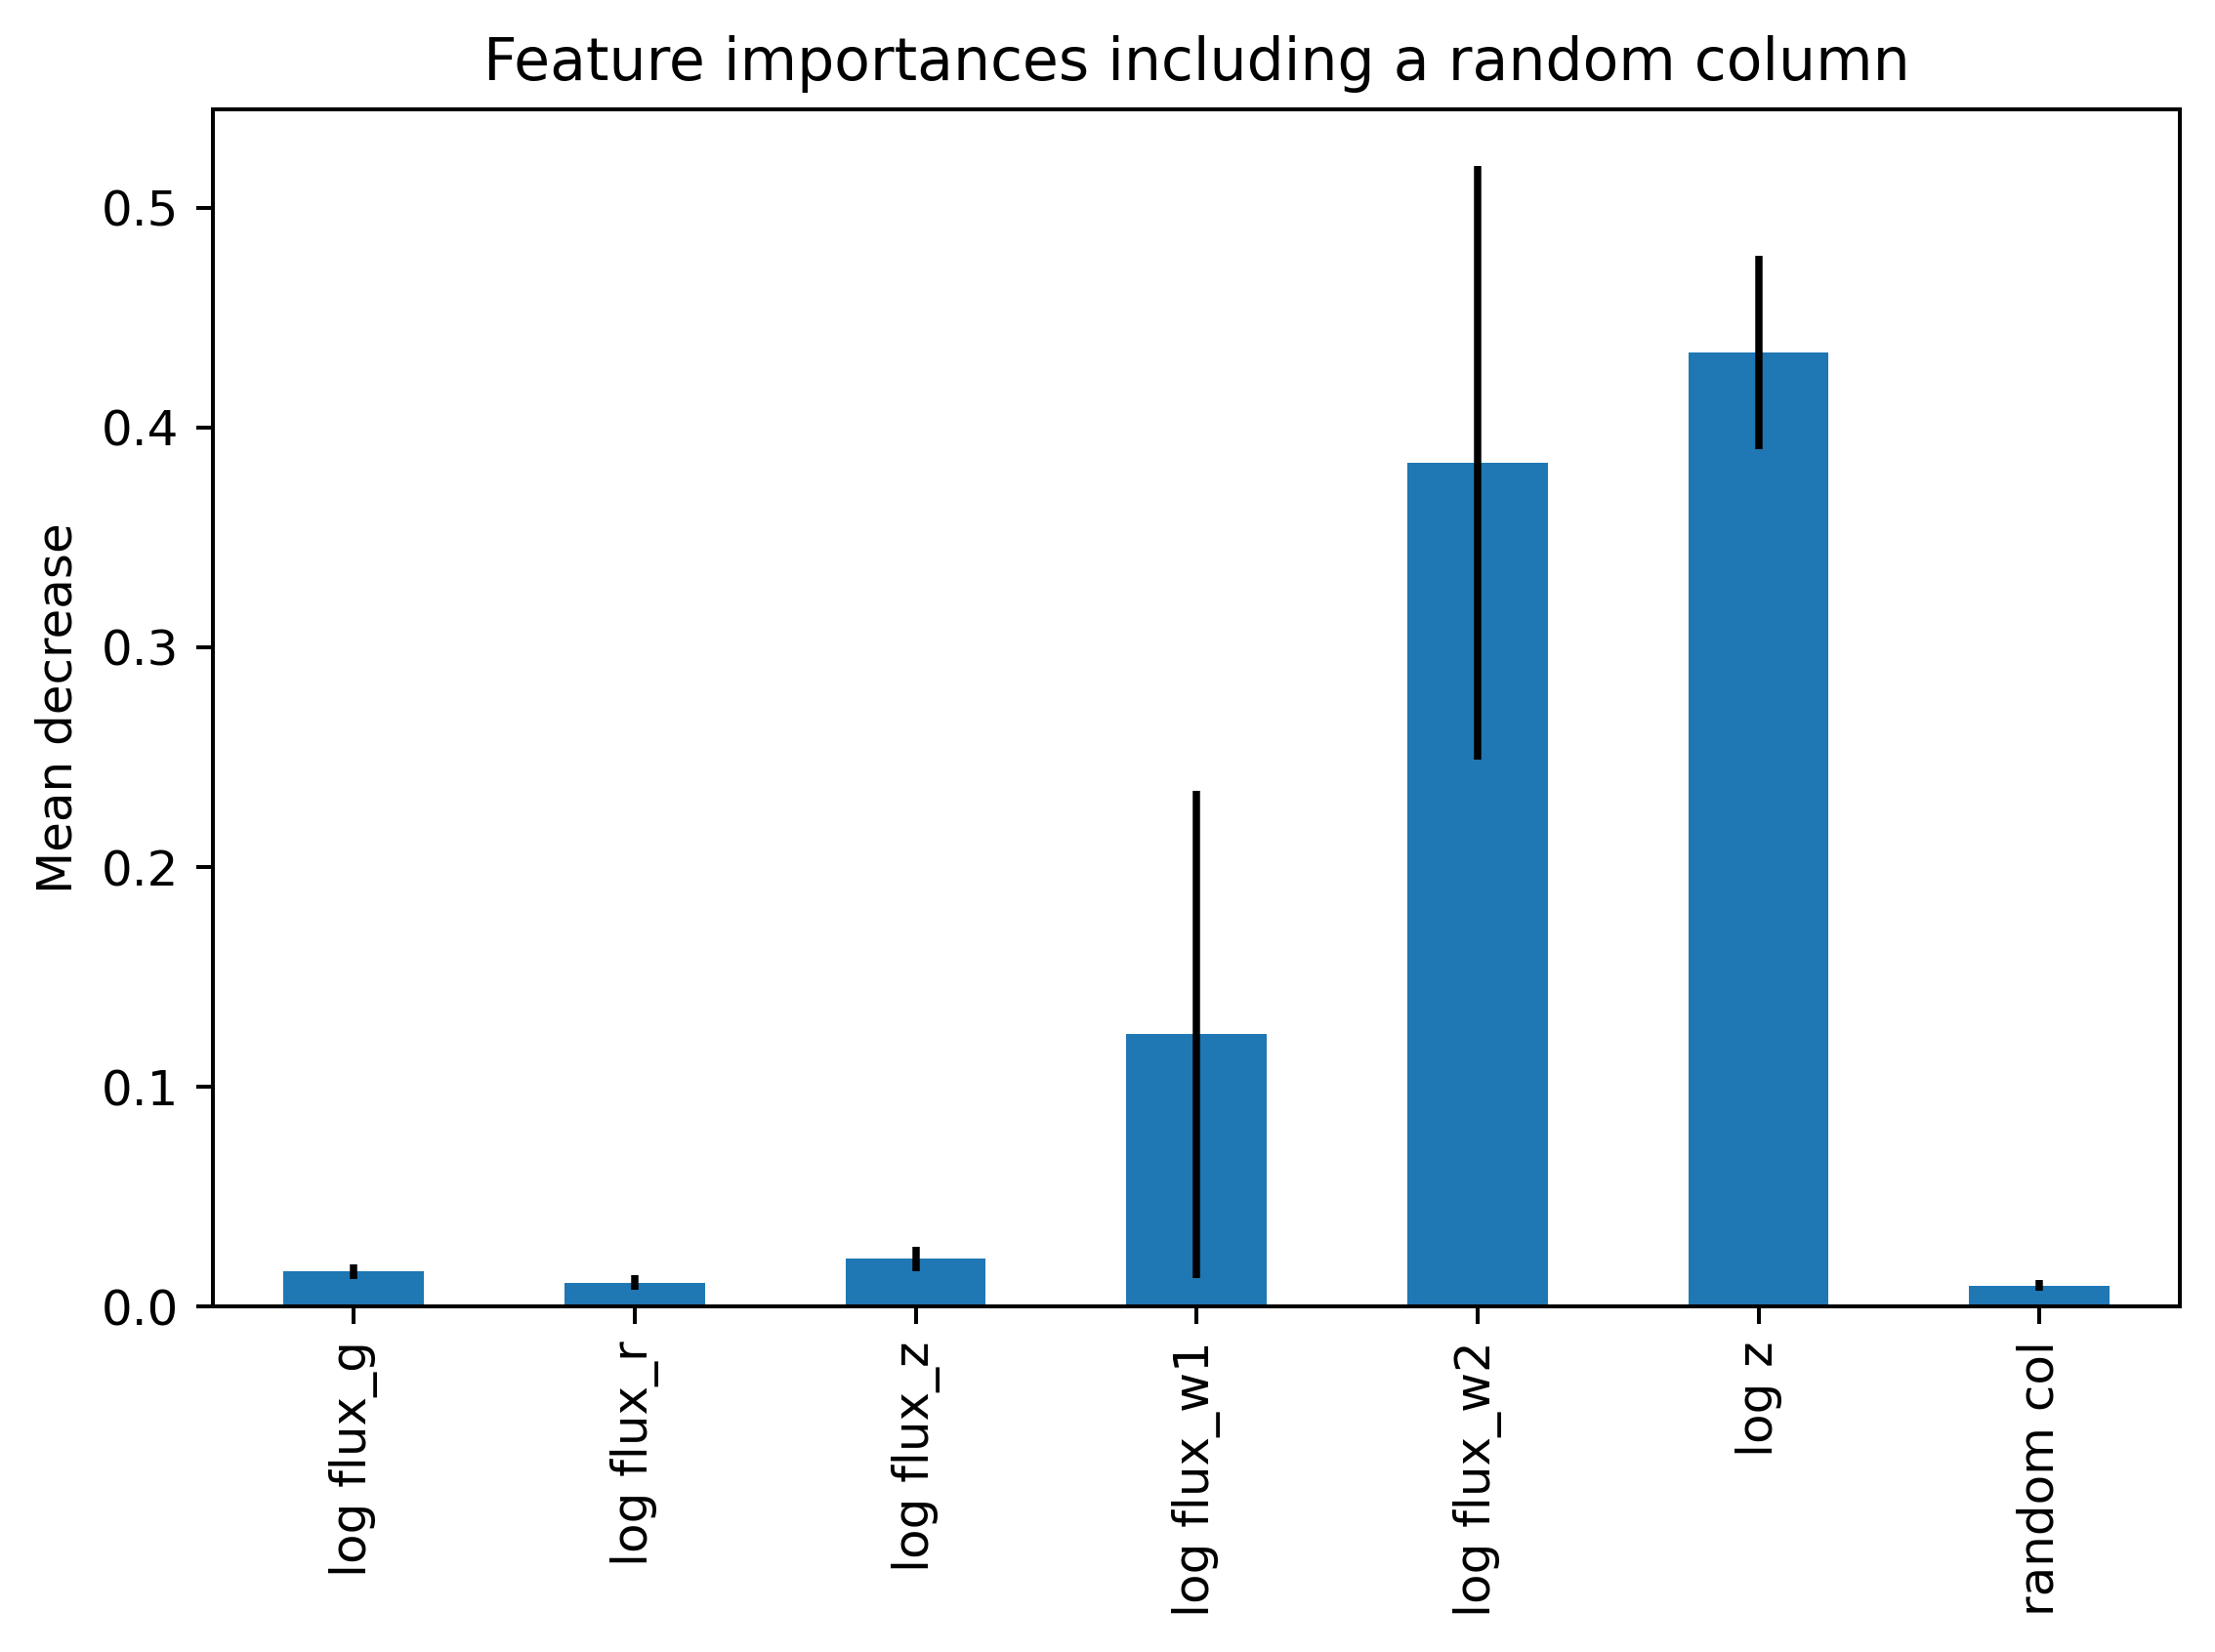

In [115]:
importances = regressor_rdm.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor_rdm.estimators_], axis=0)

props = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z', 'random col']
feature_names = [f"log {i}" for i in props[:-1]]
feature_names.append(props[-1])
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances including a random column")
ax.set_ylabel("Mean decrease")
fig.tight_layout()

Predictions in a different rosette

In [116]:
nodes, _, _ = graph_r(rosettes[2]) #Rosette 7
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]
_, X_test, _, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.044783513276565524


In [117]:
nodes, _, _ = graph_r(rosettes[1]) #Rosette 6
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]
_, X_test, _, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.04203419278273974


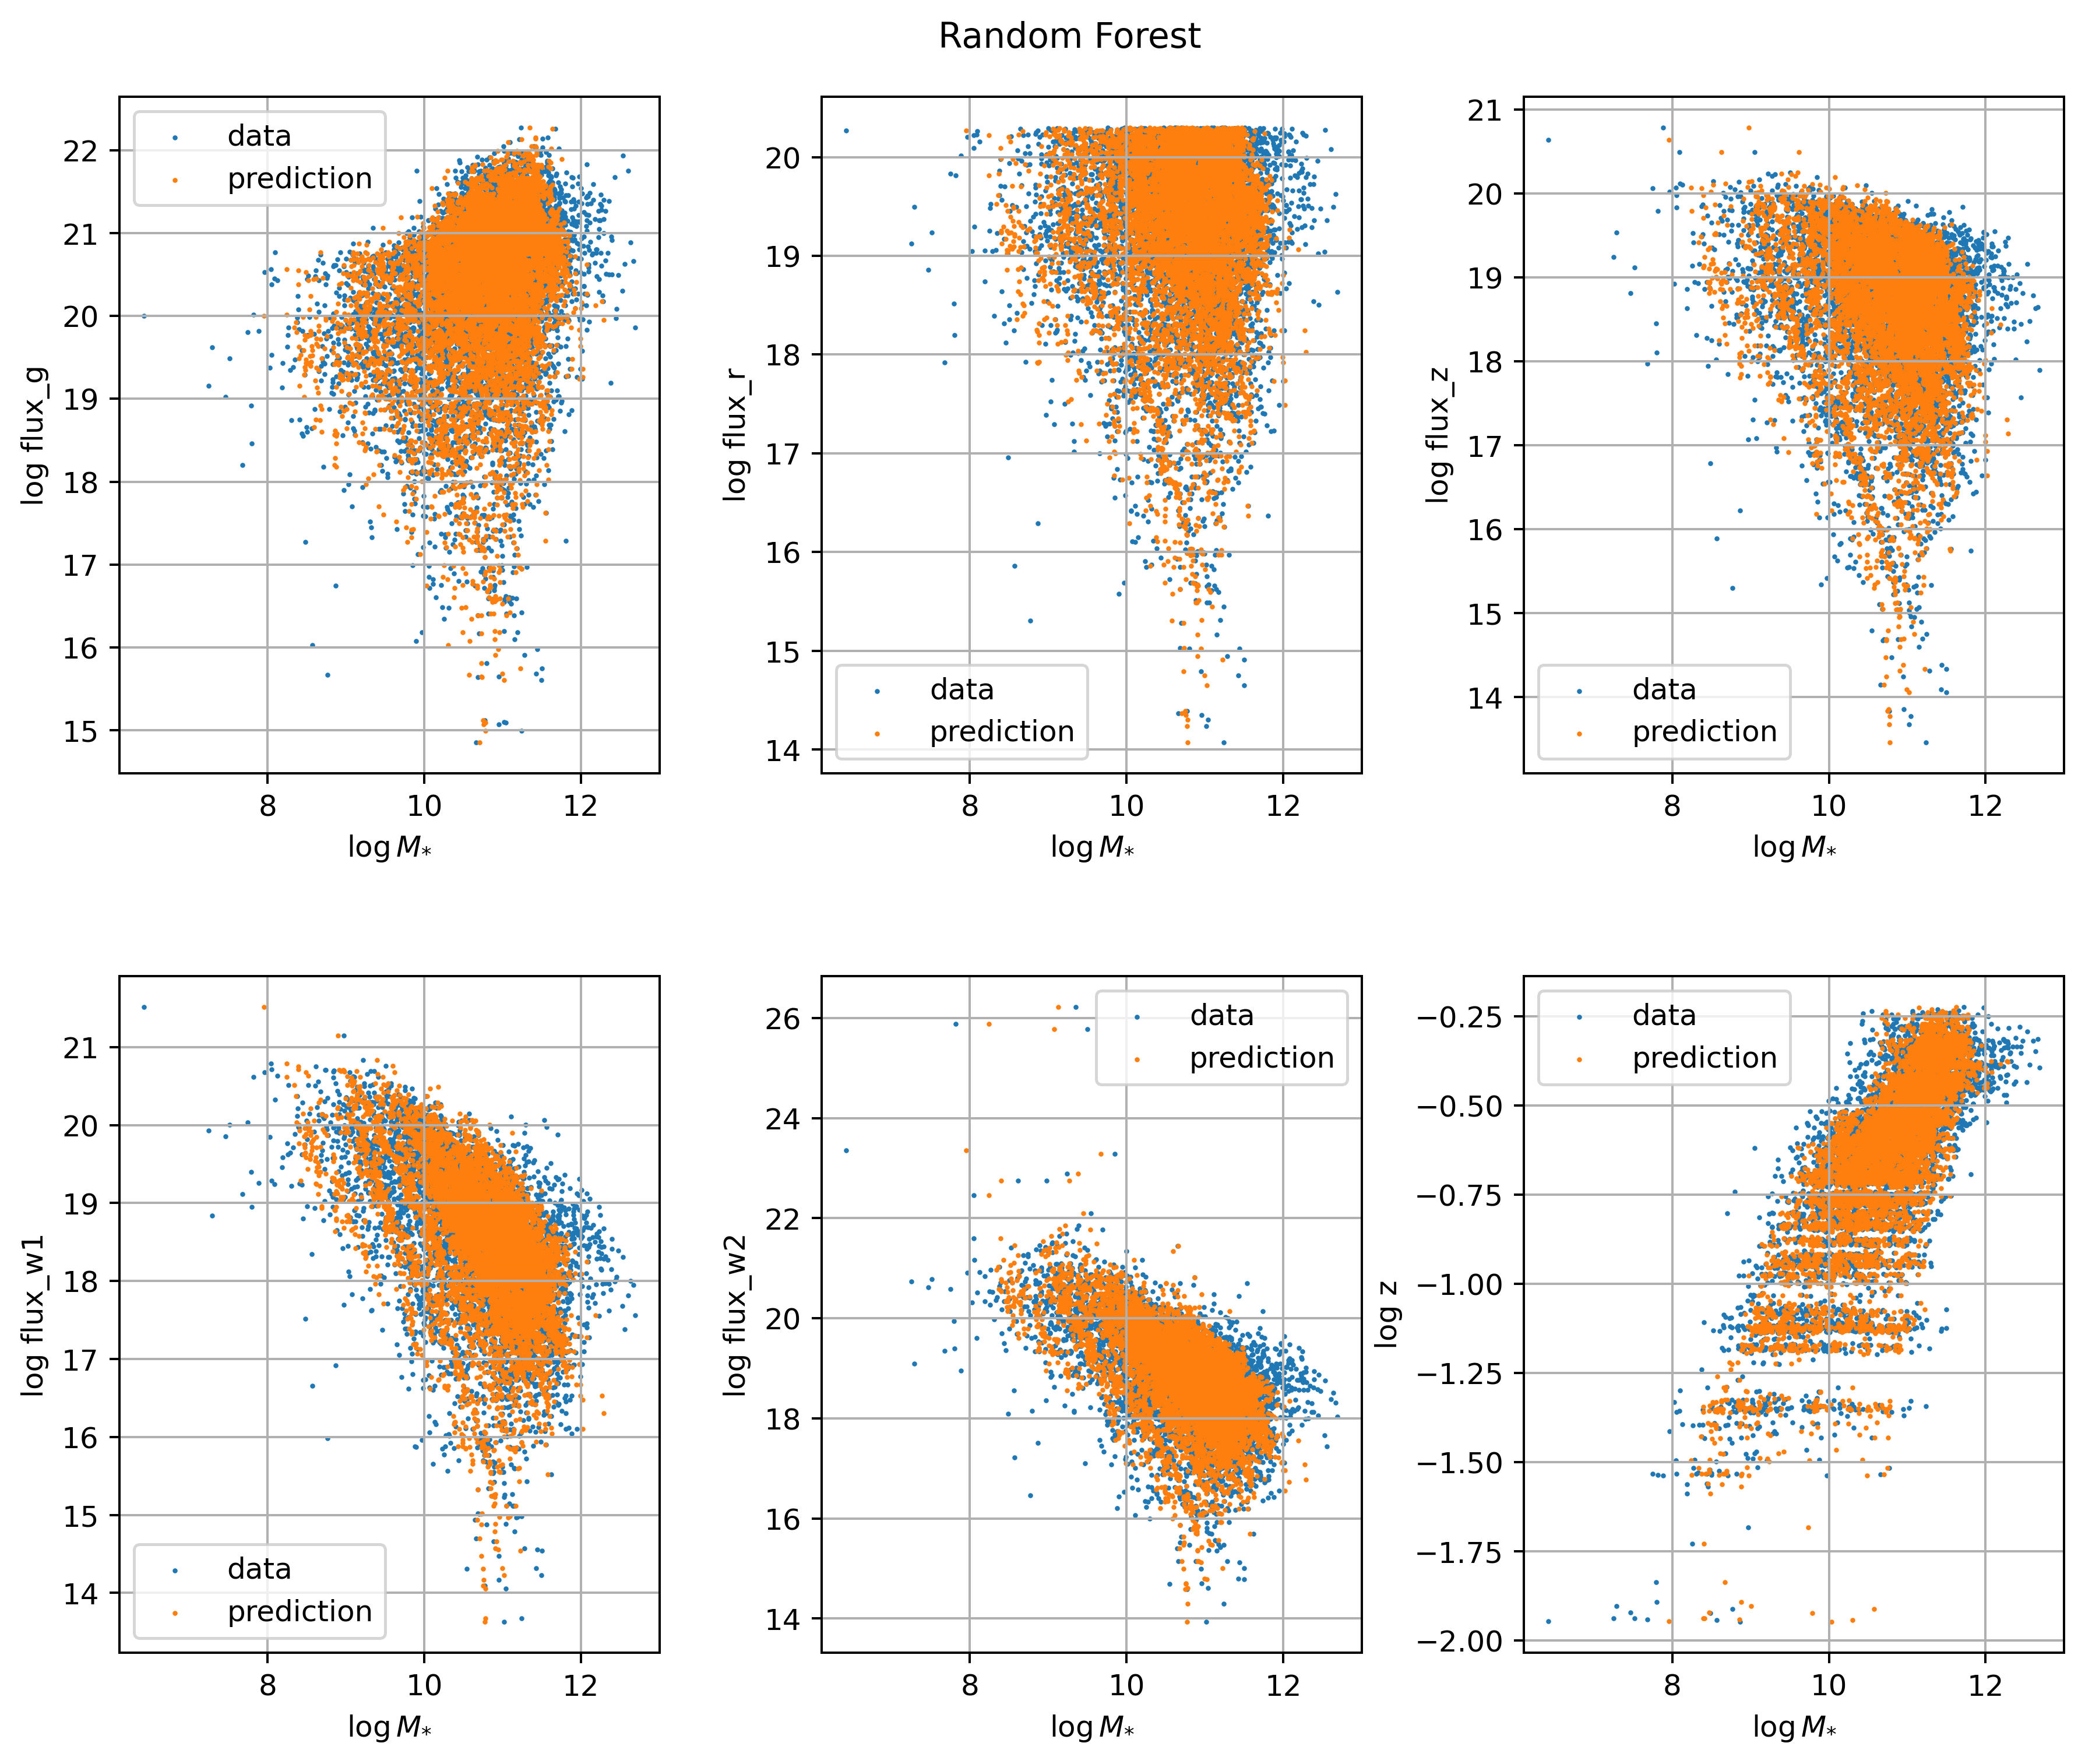

In [118]:
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle('Random Forest', y=1.02)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

X_test, y_test, y_pred = np.array(X_test), np.array(y_test), np.array(y_pred)

labels = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']

for i in range(2):
    for j in range(3):
        prop_index = i * 3 + j
        axes[i, j].scatter(y_test, X_test[:, prop_index], s=0.5, label='data')
        axes[i, j].scatter(y_pred, X_test[:, prop_index], s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'log {labels[prop_index]}')
        axes[i, j].grid()

plt.show()

### Mean squared error results

<div style="text-align:center; display: flex; justify-content: center;">
  <table>
    <tr>
      <th style="border: none;"></th>
      <th colspan="2">mse</th>
    </tr>
    <tr>
      <th>Data</th>
      <th>Linear</th>
      <th>Random Forest</th>
    </tr>
    <tr>
      <td>Train (Rosette 3)</td>
      <td>0.0349</td>
      <td>0.0357</td>
    </tr>
    <tr>
      <td>Test (Rosette 6)</td>
      <td>0.0376</td>
      <td>0.0420</td>
    </tr>
    <tr>
      <td>Test (Rosette 7)</td>
      <td>0.0366</td>
      <td>0.0447</td>
    </tr>
  </table>
</div>
